In [1]:
import os
import pandas as pd
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

In [2]:
import pm4py

In [3]:
def extractObjects(ocel):
    df = pd.DataFrame(ocel.objects)
    grouped = df.groupby('ocel:type')

    # Create a dictionary to store DataFrames for each group
    type_dataframes = {}

    # Iterate through each group and store it in the dictionary
    for group_name, group_data in grouped:
        type_dataframes[group_name] = group_data.copy()

    # Drop empty columns
    for type_name, type_dataframe in type_dataframes.items():
        type_dataframes[type_name].dropna(axis=1, how='all', inplace=True)

    return type_dataframes

def extractObjectsDF(df):
    grouped = df.groupby('ocel:type')

    # Create a dictionary to store DataFrames for each group
    type_dataframes = {}

    # Iterate through each group and store it in the dictionary
    for group_name, group_data in grouped:
        type_dataframes[group_name] = group_data.copy()

    # Drop empty columns
    for type_name, type_dataframe in type_dataframes.items():
        type_dataframes[type_name].dropna(axis=1, how='all', inplace=True)

    return type_dataframes

#returns a list of all object types when given the data frame

def extractObjectTypes(objects):
    objectTypes = list(objects.keys())
    return objectTypes


In [4]:
def adjustLogOLD(log):
    o2os=log.o2o
    objects=log.objects
    # Filter objects dataframe to get items and products
    items = objects[objects["ocel:type"] == "items"]
    products = objects[objects["ocel:type"] == "products"]

    # Filter o2os to get only the relationships where qualifier is "is a"
    is_a_relationships = o2os[o2os["ocel:qualifier"] == "is a"]

    # Merge is_a_relationships with items to get items associated with products
    items_with_relationships = items.merge(is_a_relationships, left_on="ocel:oid", right_on="ocel:oid")

    # Merge with products to get the product attributes
    items_with_product = items_with_relationships.merge(products, left_on="ocel:oid_2", right_on="ocel:oid", suffixes=("_item", "_product"))

    # Add the new 'product' column with the product id
    items_with_product['product'] = items_with_product['ocel:oid_product']

    # Select the relevant columns (including the new 'product' column)
    items_with_product = items_with_product[["ocel:oid_item", "role_item", "weight_item", "price_item", "ocel:type_item", "product"]]
    items_with_product.columns = ["ocel:oid", "role", "weight", "price", "ocel:type", "product"]

    # Remove products from the original objects dataframe
    objects_no_products = objects[objects["ocel:type"] != "products"]

    # Update the objects dataframe with the new items_with_product dataframe
    objects_updated = objects_no_products.merge(items_with_product, on=["ocel:oid", "role", "weight", "price", "ocel:type"], how="left")
    
    product_oids = objects[objects["ocel:type"] == "products"]["ocel:oid"].tolist()

    # Filter the 'o2os' dataframe to exclude rows where 'ocel:oid' or 'ocel:oid_2' is in 'product_oids'
    o2os_filtered = o2os[~(o2os["ocel:oid"].isin(product_oids) | o2os["ocel:oid_2"].isin(product_oids))]

    # Ensure product column is placed to the right
    columns = objects_no_products.columns.tolist() + ['product']
    objects_updated = objects_updated[columns]
    # Custom function to determine if an item is premium
    df = objects_updated
    def is_premium(row):
        if pd.notna(row['price']):
            return row['price'] > 500.0
        return None

    # Add a new column 'is_premium' using the custom function
    df['is_premium'] = df.apply(is_premium, axis=1)
    
    
    
    
    # Define a function to estimate volume based on weight
    def calculate_volume(row):
        if row['ocel:type'] == 'packages':
            weight = row['weight']
            # Define thresholds for volume based on weight
            if weight < 1:
                # Small package: volume is weight * 4000 (more compact)
                return weight * 4000
            elif 1 <= weight <= 5:
                # Medium package: volume is weight * 5000
                return weight * 5000
            else:
                # Large package: volume is weight * 6000 (bulkier packaging)
                return weight * 6000
        else:
            # Return NaN for non-package types
            return np.nan

    # Apply the function to each row to create the 'volume' column
    df['volume'] = df.apply(calculate_volume, axis=1)
        
    objects_updated = df
        
    return objects_updated,o2os_filtered

In [5]:
def adjustLog(log):
    objects=log.objects
    o2os = log.o2o
    df = objects
    def is_premium(row):
        if pd.notna(row['price']):
            return row['price'] > 500.0
        return None

    # Add a new column 'is_premium' using the custom function
    df['is_premium'] = df.apply(is_premium, axis=1)
    
    objects = df
    
    # Step 1: Filter `objects` to get only customers and their `kdtyp`
    # Rename `ocel:oid` as `customer_oid` for clarity
    customers = objects[objects['ocel:type'] == 'customers'][['ocel:oid', 'kdtyp']].copy()
    customers = customers.rename(columns={'ocel:oid': 'customer_oid'})

    # Step 2: Filter `o2os` for "places" relationships
    # Here, `ocel:oid` is the customer, and `ocel:oid_2` is the order
    order_customer_relationships = o2os[o2os['ocel:qualifier'] == 'places'][['ocel:oid', 'ocel:oid_2']].copy()
    order_customer_relationships = order_customer_relationships.rename(columns={'ocel:oid': 'customer_oid', 'ocel:oid_2': 'order_oid'})


    # Step 3: Merge `order_customer_relationships` with `customers` to bring `kdtyp` into each order
    order_with_kdtyp = order_customer_relationships.merge(customers, on='customer_oid', how='left')


    # Step 4: Merge `order_with_kdtyp` back with the original `objects` DataFrame to add `kdtyp` to orders
    # This will add `kdtyp` to each order in the original `objects` DataFrame based on the linked customer
    final_objects = objects.merge(order_with_kdtyp[['order_oid', 'kdtyp']], left_on='ocel:oid', right_on='order_oid', how='left')

    # Drop the extra `order_oid` column since `ocel:oid` already represents the order ID
    final_objects = final_objects.drop(columns=['order_oid'])

    # Merge the two `kdtyp` columns: prioritize the `kdtyp` from the orders, and use the original `kdtyp` where it exists for customers
    final_objects['kdtyp'] = final_objects['kdtyp_x'].fillna(final_objects['kdtyp_y'])

    # Drop the now-redundant `kdtyp_x` and `kdtyp_y` columns
    final_objects = final_objects.drop(columns=['kdtyp_x', 'kdtyp_y'])
    
    final_objects = final_objects[final_objects["ocel:type"].isin(["items","orders","packages"])]
    
    
    return final_objects,o2os

In [6]:
def plot(pd, title):
    # Print the resulting probability distribution
    probability_distribution = pd
    keys = list(probability_distribution.keys())
    values = list(probability_distribution.values())

    # Create a bar chart
    plt.bar(keys, values)

    # Set labels and title
    plt.xlabel('Items')
    plt.ylabel('Probability')
    plt.title(title)

    # Show the plot
    plt.show()

def getAttributes(log):
    df = pd.DataFrame(log.objects)
    typeAttributes = {}
    # Iterate over unique types
    for type_value in df['ocel:type'].unique():
        # Filter DataFrame rows for the current type
        type_df = df[df['ocel:type'] == type_value]
        
        # Get non-empty column names for the current type
        non_empty_columns = type_df.dropna(axis=1, how='all').columns.tolist()
        
        # Store non-empty column names in the dictionary
        typeAttributes[type_value] = non_empty_columns
    for type_value, column_names in typeAttributes.items():
        typeAttributes[type_value] = [col for col in column_names if col not in ['ocel:oid', 'ocel:type']]
    return(typeAttributes)

def calcORMDs(o2os,type1,type2):
    if 'ocel:qualifier' in o2os:
        o2os.drop(columns='ocel:qualifier', inplace=True)

    obs = extractObjectsDF(adjusted_log)
    id_type_dict = {}
    for key in obs:
        df = obs[key]
        new_dict = dict(zip(df['ocel:oid'], df['ocel:type']))
        id_type_dict.update(new_dict)

    o2os['ocel:type'] = o2os['ocel:oid'].map(id_type_dict)
    o2os['ocel:type_2'] = o2os['ocel:oid_2'].map(id_type_dict)
    new_order = ['ocel:oid','ocel:type','ocel:oid_2','ocel:type_2']
    o2os = o2os[new_order]

    df = o2os
    # Filter rows based on 'ocel:type' and 'ocel:type_2'
    filtered_df = df[df['ocel:type'].isin([type1]) & df['ocel:type_2'].isin([type2])]

    
    df = filtered_df

    # Step 2: Group by 'ocel:oid' and count the number of unique 'ocel:oid_2' values
    order_relations_count = filtered_df.groupby('ocel:oid')['ocel:oid_2'].nunique()

    # Create a dictionary with 'ocel:oid' of each order as keys and the count as values
    order_item_relations = dict(zip(order_relations_count.index, order_relations_count))
    values_list = list(order_item_relations.values())
    # Count the occurrences of each integer
    integer_list = values_list
    counts = Counter(integer_list)

    # Calculate the total number of elements in the list
    total_elements = len(integer_list)

    # Create a probability distribution by dividing the count of each integer by the total number of elements
    probability_distribution1 = {key: count / total_elements for key, count in counts.items()}

    #reverse ORMD:


    def swap(row,index):
        t2 = row['ocel:type_2']
        id2 = row['ocel:oid_2']
        df.at[index, 'ocel:type_2'] = row["ocel:type"]
        df.at[index, 'ocel:oid_2'] = row["ocel:oid"]
        df.at[index, 'ocel:type'] = t2
        df.at[index, 'ocel:oid'] = id2


    for index, row in df.iterrows():
        if row["ocel:type_2"] == type2:
            swap(row,index)

    filtered_df = df

    # Step 2: Group by 'ocel:oid' and count the number of unique 'ocel:oid_2' values
    order_relations_count = filtered_df.groupby('ocel:oid')['ocel:oid_2'].nunique()

    # Create a dictionary with 'ocel:oid' of each order as keys and the count as values
    order_item_relations = dict(zip(order_relations_count.index, order_relations_count))
    values_list = list(order_item_relations.values())
    # Count the occurrences of each integer
    integer_list = values_list
    counts = Counter(integer_list)

    # Calculate the total number of elements in the list
    total_elements = len(integer_list)

    # Create a probability distribution by dividing the count of each integer by the total number of elements
    probability_distribution2 = {key: count / total_elements for key, count in counts.items()}


    return(probability_distribution1, probability_distribution2)


def support(action,ORMDS,AORMDS):

    if action["action"]== "emit":
        if action["direction"]== 0:
            ob1 = action["object"]
            X = 0
            Y = 0
            ob1rels = ob1.relations
            for ob in ob1rels:
                if ob.type == action["type"]:
                    X = X+1
            if ((ob1.type,action["type"]) in ORMDS):
                ob1perob2 = ORMDS[ob1.type,action["type"]][0]
                ob2perob1 = ORMDS[ob1.type,action["type"]][1]
            else:
                for key, value in AORMDS.items():
                    if key[0] == ob1.type and key[1] == action["type"]:
                        mia = key[2]
                        break
                ob1perob2 = AORMDS[ob1.type,action["type"],mia,ob1.attributes[mia]][0]
                ob2perob1 = AORMDS[ob1.type,action["type"],mia,ob1.attributes[mia]][1]
            

            if ob1perob2 == {}:
                return 0
            if ob2perob1 == {}:
                return 0
            probXintersect = sum(ob1perob2[x] for x in ob1perob2 if x>=X+1)
            probXgeq = sum(ob1perob2[x] for x in ob1perob2 if x>= X)
            conditionalProb1 = probXintersect / probXgeq
            probYintersect = sum(ob2perob1[x] for x in ob2perob1 if x>=Y+1)
            probYgeq = sum(ob2perob1[x] for x in ob2perob1 if x>= Y)
            conditionalProb2 = probYintersect / probYgeq


            return min(conditionalProb1,conditionalProb2)
        if action["direction"]== 1:
            ob2 = action["object"]
            X = 0
            Y = 0
            for obj in ob2.reverse_relations:
                if obj.type==action["type"]:
                    Y=Y+1
            if ((action["type"],ob2.type) in ORMDS):
                ob1perob2 = ORMDS[action["type"],ob2.type][0]
                ob2perob1 = ORMDS[action["type"],ob2.type][1]
            else:
                for key, value in AORMDS.items():
                    if key[0] == action["type"] and key[1] == ob2.type:
                        mia = key[2]
                        break
                ob1perob2 = AORMDS[action["type"],ob2.type,mia,"PR"][0]
                ob2perob1 = AORMDS[action["type"],ob2.type,mia,"PR"][1]
            
            if ob1perob2 == {}:
                return 0
            if ob2perob1 == {}:
                return 0
            probXintersect = sum(ob1perob2[x] for x in ob1perob2 if x>=X+1)
            probXgeq = sum(ob1perob2[x] for x in ob1perob2 if x>= X)
            conditionalProb1 = probXintersect / probXgeq
            probYintersect = sum(ob2perob1[x] for x in ob2perob1 if x>=Y+1)
            probYgeq = sum(ob2perob1[x] for x in ob2perob1 if x>= Y)
            conditionalProb2 = probYintersect / probYgeq


            return min(conditionalProb1,conditionalProb2)

    if action["action"]== "append":
        ob2 = action["object2"]
        ob1 = action["object1"]
    
        if ob2 == ob1:
            return 0
        X = 0
        Y = 0


        ob1rels = ob1.relations
        for ob in ob1rels:
            if ob.type == ob2.type:
                X = X+1
        ob2rels = ob2.relations
        # Zähle wie oft insgesamt auf ob2 gezeigt wird von objekten von typ ob1.type
        for obj in ob2.reverse_relations:
            if obj.type==ob1.type:
                Y=Y+1
        #for ob in ob2rels:
        #    if ob.type == ob1.type:
        #        Y = Y+1
        
        if ((ob1.type,ob2.type) in ORMDS):
            ob1perob2 = ORMDS[ob1.type,ob2.type][0]
            ob2perob1 = ORMDS[ob1.type,ob2.type][1]
        else:
            for key, value in AORMDS.items():
                    if key[0] == ob1.type and key[1] == ob2.type:
                        mia = key[2]

                        ob1perob2 = AORMDS[ob1.type,ob2.type,mia,ob1.attributes[mia]][0]
                        ob2perob1 = AORMDS[ob1.type,ob2.type,mia,ob1.attributes[mia]][1]
                        break



        if ob1perob2 == {}:
            return 0
        if ob2perob1 == {}:
            return 0

        probXintersect = sum(ob1perob2[x] for x in ob1perob2 if x>= X and x>=X+1)
        probXgeq = sum(ob1perob2[x] for x in ob1perob2 if x>= X)
        conditionalProb1 = probXintersect / probXgeq
        probYintersect = sum(ob2perob1[x] for x in ob2perob1 if x>= Y and x>=Y+1)
        probYgeq = sum(ob2perob1[x] for x in ob2perob1 if x>= Y)
        if probYgeq == 0:
            return 0
        conditionalProb2 = probYintersect / probYgeq
        

        return min(conditionalProb1,conditionalProb2)
        
    return 0.5





In [7]:
def calcAORMDs(o2os,objectdf,type1,type2,specialAtt,value):
    if 'ocel:qualifier' in o2os:
        o2os.drop(columns='ocel:qualifier', inplace=True)
    
    obs = extractObjectsDF(adjusted_log)
    #under the assumption that object of type1 has this particular specialAtt value

    
    id_type_dict = {}
    for key in obs:
        df = obs[key]
        new_dict = dict(zip(df['ocel:oid'], df['ocel:type']))
        id_type_dict.update(new_dict)

    o2os['ocel:type'] = o2os['ocel:oid'].map(id_type_dict)
    o2os['ocel:type_2'] = o2os['ocel:oid_2'].map(id_type_dict)
    new_order = ['ocel:oid','ocel:type','ocel:oid_2','ocel:type_2']
    o2os = o2os[new_order]

    # Merge o2os with objects to include the specialAtt column based on ocel:oid_1
    merged_df = o2os.merge(objectdf[['ocel:oid', specialAtt]], on='ocel:oid', how='left')


    
    df = merged_df
    # Filter rows based on 'ocel:type' and 'ocel:type_2'
    filtered_df = df[df['ocel:type'].isin([type1]) & df['ocel:type_2'].isin([type2])&df[specialAtt].isin([value])]

    
    df = filtered_df


    # Step 2: Group by 'ocel:oid' and count the number of unique 'ocel:oid_2' values
    order_relations_count = filtered_df.groupby('ocel:oid')['ocel:oid_2'].nunique()

    # Create a dictionary with 'ocel:oid' of each order as keys and the count as values
    order_item_relations = dict(zip(order_relations_count.index, order_relations_count))
    values_list = list(order_item_relations.values())
    # Count the occurrences of each integer
    integer_list = values_list
    counts = Counter(integer_list)

    # Calculate the total number of elements in the list
    total_elements = len(integer_list)

    # Create a probability distribution by dividing the count of each integer by the total number of elements
    probability_distribution1 = {key: count / total_elements for key, count in counts.items()}

    #reverse ORMD:


    def swap(row,index):
        t2 = row['ocel:type_2']
        id2 = row['ocel:oid_2']
        df.at[index, 'ocel:type_2'] = row["ocel:type"]
        df.at[index, 'ocel:oid_2'] = row["ocel:oid"]
        df.at[index, 'ocel:type'] = t2
        df.at[index, 'ocel:oid'] = id2


    for index, row in df.iterrows():
        if row["ocel:type_2"] == type2:
            swap(row,index)

    filtered_df = df

    # Step 2: Group by 'ocel:oid' and count the number of unique 'ocel:oid_2' values
    order_relations_count = filtered_df.groupby('ocel:oid')['ocel:oid_2'].nunique()

    # Create a dictionary with 'ocel:oid' of each order as keys and the count as values
    order_item_relations = dict(zip(order_relations_count.index, order_relations_count))
    values_list = list(order_item_relations.values())
    # Count the occurrences of each integer
    integer_list = values_list
    counts = Counter(integer_list)

    # Calculate the total number of elements in the list
    total_elements = len(integer_list)

    # Create a probability distribution by dividing the count of each integer by the total number of elements
    probability_distribution2 = {key: count / total_elements for key, count in counts.items()}


    return(probability_distribution1, probability_distribution2)

In [8]:

log = pm4py.read.read_ocel2_sqlite("order-management5.sqlite")
adjusted_log,adjusted_o2os = adjustLog(log)
objectdf = adjustLog(log)[0]

c:\Users\armin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pm4py\objects\ocel\importer\sqlite\variants\ocel20.py:70: UserWarning: There are unsatisfied OCEL 2.0 constraints in the given relational database: ['const_14_primary_key_object_event_map_type_tables', 'const_15_primary_key_object_event_tables', 'const_16_primary_key_event_object_table', 'const_17_primary_key_object_object_table', 'const_18_primary_key_event_type_spec_tables', 'const_19_foreign_key_event', 'const_20_foreign_key_object', 'const_21_foreign_key_event_object', 'const_22_foreign_key_object_object', 'const_23_foreign_key_event_type_specific', 'const_24_foreign_key_object_type_specific']
  warnings.warn("There are unsatisfied OCEL 2.0 constraints in the given relational database: "+str(unsatisfied))
c:\Users\armin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [9]:
calcAORMDs(adjusted_o2os,objectdf,"orders","items","kdtyp","PR")[0]

{5: 0.1834016393442623,
 6: 0.14754098360655737,
 7: 0.08913934426229508,
 3: 0.15881147540983606,
 4: 0.24282786885245902,
 9: 0.027663934426229508,
 2: 0.07581967213114754,
 12: 0.006147540983606557,
 8: 0.05430327868852459,
 11: 0.005122950819672131,
 13: 0.0030737704918032786,
 10: 0.006147540983606557}

In [10]:
#method takes dataframe of possible attribute values, 
#type attributes is a map of maps: typeAttributes[type]-> attributes{} ; attributes[att]-> "independent" / "dependent"

def generateIndependendAtts(typeAttributes,objectdf,type,classifier):
    attr = {}
    for a in typeAttributes[type]:
        if typeAttributes[type][a] == "independent":
            if classifier[a]== "ca":
                    df = objectdf
                    l = df.loc[df['ocel:type'] == type, a].tolist()
                    #sampling values
                    unique_values, counts = np.unique(l, return_counts=True)
                    probabilities = counts / len(l)
                    attr[a] = np.random.choice(unique_values,p=probabilities)
            if classifier[a]== "di":
                    df = objectdf
                    l = df.loc[df['ocel:type'] == type, a].tolist()
                    #sampling values
                    unique_values, counts = np.unique(l, return_counts=True)
                    probabilities = counts / len(l)
                    attr[a] = np.random.choice(unique_values,p=probabilities)
            if classifier[a]=="co": 
                    df = objectdf
                    l = df.loc[df['ocel:type'] == type, a].tolist()
                    #sampling values
                    unique_values, counts = np.unique(l, return_counts=True)
                    probabilities = counts / len(l)
                    attr[a] = np.random.choice(unique_values,p=probabilities)

    return attr

In [11]:
def generateDependendAtts(typeAttributes,dependencies,type,independentAtts,distributions,objectdf,classifier):
    #get list of dependencies then assign values to dependent attributes accordingly
    #dependencies: independentAtt -> dependentAtt[]
    #to simplify: every attribute is dependent on a maximum of one independent attribute but multiple attributes can be dependent on this independent attribute
    attr = {}
    for a in typeAttributes[type]:
        if typeAttributes[type][a] == "dependent":
            #a is the dependent attribute i want to generate
            #now i need to find out on which independent attribute it depends
            for indAtt in dependencies:
                if a in dependencies[indAtt]:
                    #indAtt is the independent attribute that 'a' is dependent on
                    val = independentAtts[indAtt]
                    #check if a distribution of values for my attribute 'a' from datapoints in which my object had the attribute value of indAtt exists
                    #if not create one
                    if (a,indAtt,val) in distributions:
                        dist = distributions[(a,indAtt,val)]
                        unique_values = list(dist.keys())
                        unique_values = np.array(unique_values)
                        probabilities = list(dist.values())
                        if classifier[a]=="ca":
                             attr[a]= random.choices(unique_values,probabilities)[0]
                        if classifier[a]=="co": 
                            interpolated_pdf = interp1d(unique_values, probabilities, kind='linear', fill_value="extrapolate")
                            
                            # Define a fine grid over the range of values
                            x_fine = np.linspace(unique_values.min(), unique_values.max(), 1000)
                            pdf_fine = interpolated_pdf(x_fine)

                            # Integrate the PDF to get the cumulative distribution function (CDF)
                            cdf_fine = cumtrapz(pdf_fine, x_fine, initial=0)
                            cdf_fine /= cdf_fine[-1]  # Normalize the CDF

                            # Function to generate a random value based on the PDF
                            def generate_random_value(cdf, x_vals):
                                random_uniform = np.random.rand()
                                return np.interp(random_uniform, cdf, x_vals)
                            # Generate a random value
                            random_value = generate_random_value(cdf_fine, x_fine)
                            attr[a]= random_value
                    else:
                        l = objectdf.loc[objectdf[indAtt] == val, a].tolist()
                        # Step 1: Count the frequency of each value
                        frequency_counts = Counter(l)
                        # Step 2: Convert frequencies to probabilities
                        total_count = len(l)
                        dist = {value: count / total_count for value, count in frequency_counts.items()}
                        distributions[(a,indAtt,val)] = dist
                        unique_values = list(dist.keys())
                        unique_values = np.array(unique_values)
                        probabilities = list(dist.values())
                        if classifier[a]=="ca":
                             attr[a]= random.choices(values,probabilities)[0]
                        if classifier[a]=="co": 
                            interpolated_pdf = interp1d(unique_values, probabilities, kind='linear', fill_value="extrapolate")
                            
                            # Define a fine grid over the range of values
                            x_fine = np.linspace(unique_values.min(), unique_values.max(), 1000)
                            pdf_fine = interpolated_pdf(x_fine)

                            # Integrate the PDF to get the cumulative distribution function (CDF)
                            cdf_fine = cumtrapz(pdf_fine, x_fine, initial=0)
                            cdf_fine /= cdf_fine[-1]  # Normalize the CDF

                            # Function to generate a random value based on the PDF
                            def generate_random_value(cdf, x_vals):
                                random_uniform = np.random.rand()
                                return np.interp(random_uniform, cdf, x_vals)
                            # Generate a random value
                            random_value = generate_random_value(cdf_fine, x_fine)
                            attr[a]= random_value
                                      
    return attr,distributions

In [12]:
def generateDependendAttsnew(typeAttributes,dependencies,type,independentAtts,distributions,objectdf,parentAtts,o2os,classifier):
    #get dependencies then assign values to dependent attributes accordingly
    #dependencies: independentAtt,type -> [(dependentAtt,type),...]
    #to simplify: every attribute type combination (depAtt,ot) is dependent on a maximum of one independent attribute of a type (indAtt,ot') but multiple attribute type combinations (depAtt1,ot1),...,(depAttn,otn) can be dependent on this independent attribute with corresponding type
    attr = {}
    for a in typeAttributes[type]:
        if typeAttributes[type][a] == "dependent":
            #a is the dependent attribute I want to generate
            #now I need to find out on which independent attribute it depends
            for indAtt,otype in dependencies:
                if any(tup[0] == a for tup in dependencies[(indAtt, otype)]):
                    #indAtt is the independent attribute that 'a' is dependent on
                    #otype is the type of object that is involved in the dependency
                    if type == otype:
                        val = independentAtts[indAtt]
                        #check if a distribution of values for my attribute 'a' from datapoints in which my object had the attribute value of indAtt exists
                        #if not create one
                        if (a,indAtt,val,type) in distributions:
                            dist = distributions[(a,indAtt,val,type)]
                            unique_values = list(dist.keys())
                            unique_values = np.array(unique_values)
                            probabilities = list(dist.values())
                            attr[a]= random.choices(unique_values,probabilities)[0]
                                
                        else:
                            l = objectdf.loc[(objectdf[indAtt] == val) & (objectdf['ocel:type'] == type), a].tolist()
                            # Step 1: Count the frequency of each value
                            frequency_counts = Counter(l)
                            # Step 2: Convert frequencies to probabilities
                            total_count = len(l)
                            dist = {value: count / total_count for value, count in frequency_counts.items()}
                            distributions[(a,indAtt,val,type)] = dist
                            unique_values = list(dist.keys())
                            unique_values = np.array(unique_values)
                            probabilities = list(dist.values())
                            attr[a]= random.choices(unique_values,probabilities)[0]
                    else:
                        if indAtt in parentAtts:
                            val = parentAtts[indAtt]
                            if classifier[a]!="co" or classifier[indAtt]!="co": 
                                if (a,indAtt,val) in distributions:
                                    dist = distributions[(a,indAtt,val)]
                                    unique_values = list(dist.keys())
                                    unique_values = np.array(unique_values)
                                    probabilities = list(dist.values())
                                    attr[a]= random.choices(unique_values,probabilities)[0]
                                else:
                                    l = objectdf.loc[(objectdf[indAtt] == val) & (objectdf["ocel:type"] == otype), 'ocel:oid'].tolist() 
                                    l2 = o2os.loc[(o2os['ocel:oid'] in l) & (o2os['ocel:type']== type),'ocel:oid_2'].tolist()
                                    l3 = objectdf.loc[objectdf['ocel:oid'] in l2 , a].tolist()

                                    frequency_counts = Counter(l3)
                                    total_count = len(l3)
                                    dist = {value: count / total_count for value, count in frequency_counts.items()}
                                    distributions[(a,indAtt,val,type)] = dist
                                    unique_values = list(dist.keys())
                                    unique_values = np.array(unique_values)
                                    probabilities = list(dist.values())
                                    attr[a]= random.choices(unique_values,probabilities)[0]
                            else:
                                #hier interpolieren 
                                # Step 1: Filter objectdf to get the mapping from 'ocel:oid' to 'indAtt' for ids in list 'l'
                                filtered_objectdf = objectdf[objectdf['ocel:oid'].isin(l)][['ocel:oid', 'indAtt']]

                                # Step 2: Merge with o2os to get corresponding 'ocel:oid_2' values
                                merged_df = filtered_objectdf.merge(o2os, left_on='ocel:oid', right_on='ocel:oid')[['indAtt', 'ocel:oid_2']]

                                # Step 3: Merge again with objectdf to get the 'a' values for the 'ocel:oid_2' objects
                                merged_with_a = merged_df.merge(objectdf[['ocel:oid', 'a']], left_on='ocel:oid_2', right_on='ocel:oid', how='left')

                                # Step 4: Create a dictionary that maps each 'indAtt' to the corresponding 'a' value of 'ocel:oid_2'
                                indAtt_to_a_dict = merged_with_a.set_index('indAtt')['a'].to_dict()
                                

                                # Step 1: Prepare the data for interpolation
                                # Extract the keys and values from the dictionary and sort them by keys for proper interpolation
                                indAtt_values = sorted(indAtt_to_a_dict.keys())
                                a_values = [indAtt_to_a_dict[key] for key in indAtt_values]

                                # Step 2: Create an interpolation function
                                # You can choose 'linear', 'quadratic', or 'cubic' based on the smoothness you need
                                interpolation_function = interp1d(indAtt_values, a_values, kind='linear', fill_value="extrapolate")

                                # Step 3: Define the points you want to sample
                                # For example, you might want to sample between the min and max of indAtt_values with a certain resolution
                                sample_points = np.linspace(min(indAtt_values), max(indAtt_values), num=50)

                                # Step 4: Sample the function and add noise
                                # Here, we add Gaussian noise with mean 0 and standard deviation of your choice (e.g., 0.1)
                                noise_std_dev = 0.1
                                attr[a] = [interpolation_function(x) + random.gauss(0, noise_std_dev) for x in sample_points]

                                # Result: sample_points are your x-values, and sampled_values_with_noise are the interpolated y-values with noise

                                
                                
                        else:
                            attr[a] = "MISSING DEPENDENT ATT"

                        

                                      
    return attr,distributions

In [13]:
def fillMissingAttributes(ob1,ob2,dependencies,distributions,objectdf,o2os,classifier):
    #find out what attribute values are missing that can be generated with the new related object
    #remember that dependencies[a,ot] returns dependent attributes of in independent att a connected to type ot
    attr = ob1.attributes
    for x in ob1.attributes:
        for indAtt in ob2.attributes:
            if ob1.attributes[x] == "MISSING DEPENDENT ATT" and  any(tup[0] == x for tup in dependencies[(indAtt, ob2.type)]):
                #x is the dep att I want to generate
                #parentAtt is the ind att it is dependent on
                val = ob2.attributes[indAtt]
                if (x,indAtt,val) in distributions:
                    a=x
                    dist = distributions[(a,indAtt,val)]
                    unique_values = list(dist.keys())
                    unique_values = np.array(unique_values)
                    probabilities = list(dist.values())
                    attr[a]= random.choices(unique_values,probabilities)[0]
                else:
                    l = objectdf.loc[objectdf[indAtt] == val, 'ocel:oid'].tolist()
                    l2 = o2os.loc[o2os['ocel:oid'] in l ,'ocel:oid_2'].tolist()
                    l3 = objectdf.loc[objectdf['ocel:oid'] in l2 , a].tolist()

                    frequency_counts = Counter(l3)
                    total_count = len(l3)
                    dist = {value: count / total_count for value, count in frequency_counts.items()}
                    distributions[(a,indAtt,val,type)] = dist
                    unique_values = list(dist.keys())
                    unique_values = np.array(unique_values)
                    probabilities = list(dist.values())
                    attr[a]= random.choices(unique_values,probabilities)[0]
    return attr
                            

In [14]:
#these just return a dictionary that describes the intended action
def emit(object,  type, direction):
    return {"action": "emit", "object": object,"type": type, "direction" : direction}

def app(object, object2):
    return {"action" : "append","object1": object, "object2":object2}

def close(object, type):
    return {"action":"close","object": object,'type' :type}


class Object:
    def __init__(self,type,attributes, relations, reverse_relations,open_types) -> None:
        self.type = type
        self.attributes = attributes
        self.relations = relations
        self.reverse_relations = reverse_relations
        self.open_types = open_types

def generateGraph(objectTypes, tau, objects, support,log, limit, minObjs,typeAttributes,dependencies,o2os,mias,miaDependencies,classifier,minOrds = 1, maxOrds=2000):
    closed = []
    R = []
    OIxOT = [(item,item2) for item in objects for item2 in objectTypes if item.type == item2]
    i=2
    ORMDS = {}
    AORMDS= {}
    objectdf = adjustLog(log)[0]
    #typeAttributes = getAttributes(log)
    numOfOrds = 1
    distributions = {}
    
    
    #ORMD generation
    typePairs = [(item,item2) for item in objectTypes for item2 in objectTypes]
    for (a,b) in typePairs:
        for (specialAtt,type) in mias:
            #find out what values specialAtt can have and put them in a list
            #miaDependencies describes which multiplicities are dependent on type 1, type 2 and the value of specialAtt from the object of type1
            filtered_objectdf = objectdf[objectdf['ocel:type'] == type]
            # Get unique values from 'specialAtt' where 'ocel:type' is the specified type
            possVal = filtered_objectdf[specialAtt].unique().tolist()
            if (a,b,specialAtt) in miaDependencies:
                for val in possVal:
                    AORMDS[(a,b,specialAtt,val)]=calcAORMDs(o2os,objectdf,a,b,specialAtt,val)
            else:
                ORMDS[(a,b)] = calcORMDs(o2os,a,b)
            
        
    #special ORMDs for objects that are influenced by attributes

    notFullyClosedObjects = []
    notFullyClosedObjects= [item for item in objects]
    #(len(closed)/len(OIxOT) < tau and

    #actual object graph generation
    while ((len(objects)<limit) or len(objects)<= minObjs ):
        
        if numOfOrds>= maxOrds:
                print("order limit reached")
                return objects,R
        
            
        if notFullyClosedObjects == []:
            if numOfOrds>= minOrds:
                print("minimum order amount reached and all closed")
                return objects,R
            else:
                attr = {}
                attr["id"]= i
                independentAtts = generateIndependendAtts(typeAttributes,objectdf,"orders",classifier)
                dependentAtts,newDistributions = generateDependendAttsnew(typeAttributes,dependencies,"orders",independentAtts,distributions,objectdf,[],o2os,classifier)
                distributions = newDistributions
                attr.update(independentAtts)
                attr.update(dependentAtts)
                i= i+1
                newObject = Object("orders",attr,relations=[],reverse_relations=[],open_types=[x for x in objectTypes])
                objects.append(newObject)
                notFullyClosedObjects.append(newObject)
                numOfOrds = numOfOrds+1
                    
        o = random.choice(notFullyClosedObjects)
        otp = random.choice(o.open_types)
        ot = o.type
        OIp = [item for item in notFullyClosedObjects if item.type==otp and ((item,ot) and (o,item)) not in R]
        A = []
        A.append(emit(o,otp,0))
        A.append(emit(o,otp,1))
        for item in OIp:
            A.append(app(o,item))
        supportvals = []
        for item in A:
            supportvals.append(support(item,ORMDS,AORMDS))
        wclose = 1-max(supportvals)
        Aw = []
        for item in A:
            Aw.append(support(item,ORMDS,AORMDS))
            
        aclose = close(o,otp)
        A.append(aclose)
        Aw.append(wclose)

        alpha = random.choices(list(A), weights=list(Aw), k=1)[0]

        if alpha == emit(o,otp,0):
            attr = {}
            attr["id"]= i
            
            independentAtts = generateIndependendAtts(typeAttributes,objectdf,otp,classifier)
            dependentAtts,newDistributions = generateDependendAttsnew(typeAttributes,dependencies,otp,independentAtts,distributions,objectdf,o.attributes,o2os,classifier)
            distributions = newDistributions
            attr.update(independentAtts)
            attr.update(dependentAtts)

            i= i+1
            newObject = Object(otp,attr,relations=[],reverse_relations=[],open_types=[x for x in objectTypes])
            objects.append(newObject)
            R.append((o,newObject))
            o.relations.append(newObject)
            newObject.reverse_relations.append(o)
            notFullyClosedObjects.append(newObject)
            if otp == "orders":
                numOfOrds = numOfOrds+1
                
            for type in objectTypes:
                OIxOT.append((newObject,type))
                
        if alpha == emit(o,otp,1):
            attr = {}
            attr["id"]= i
            
            #for att in typeAttributes[otp]:
                #df = objectdf
               # l = df.loc[df['ocel:type'] == otp, att].tolist()
                #sampling values
              #  unique_values, counts = np.unique(l, return_counts=True)
             #   probabilities = counts / len(l)
            #    attr[att] = np.random.choice(unique_values,p=probabilities)
            independentAtts = generateIndependendAtts(typeAttributes,objectdf,otp,classifier)
            dependentAtts,newDistributions = generateDependendAttsnew(typeAttributes,dependencies,otp,independentAtts,distributions,objectdf,o.attributes,o2os,classifier)
            distributions = newDistributions
            attr.update(independentAtts)
            attr.update(dependentAtts)
            
            i= i+1
            newObject = Object(otp,attr,relations=[],reverse_relations=[],open_types=[x for x in objectTypes])
            objects.append(newObject)
            R.append((newObject,o))
            newObject.relations.append(o)
            o.reverse_relations.append(newObject)
            notFullyClosedObjects.append(newObject)
            if otp == "orders":
                numOfOrds = numOfOrds+1
            for type in objectTypes:
                OIxOT.append((newObject,type))
        if alpha["action"]== "append":
             op = alpha["object2"]
             o.attributes = fillMissingAttributes(o,op,dependencies,distributions,objectdf,o2os,classifier)
             op.attributes = fillMissingAttributes(op,o,dependencies,distributions,objectdf,o2os,classifier)
             R.append((o,op))
             o.relations.append(op)
             op.reverse_relations.append(o)
        if alpha == close(o,otp):
             closed.append((o,otp))
             o.open_types.remove(otp)


        if o.open_types==[]:
            notFullyClosedObjects.remove(o)
        print("total objects: "+str(i))
        print("number of orders: "+ str(numOfOrds))
        if (len(closed)/len(OIxOT) > tau):
            print("TAU OUT")

    print("LOOP ENDED")
    return (objects,R)

def graph(obs, connections):
    G = nx.DiGraph()

    for (a,b) in obs:
        G.add_node(a, label=b)
    G.add_edges_from(connections)

    pos = nx.spring_layout(G)  
    labels = nx.get_node_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=700, node_color='skyblue', font_size=8, font_color='black', font_weight='bold', arrowsize=10)
    plt.show()


In [15]:
log = pm4py.read.read_ocel2_sqlite("order-management5.sqlite")

c:\Users\armin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pm4py\objects\ocel\importer\sqlite\variants\ocel20.py:70: UserWarning: There are unsatisfied OCEL 2.0 constraints in the given relational database: ['const_14_primary_key_object_event_map_type_tables', 'const_15_primary_key_object_event_tables', 'const_16_primary_key_event_object_table', 'const_17_primary_key_object_object_table', 'const_18_primary_key_event_type_spec_tables', 'const_19_foreign_key_event', 'const_20_foreign_key_object', 'const_21_foreign_key_event_object', 'const_22_foreign_key_object_object', 'const_23_foreign_key_event_type_specific', 'const_24_foreign_key_object_type_specific']
  warnings.warn("There are unsatisfied OCEL 2.0 constraints in the given relational database: "+str(unsatisfied))
c:\Users\armin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [16]:
newLog,newo2os = adjustLog(log)

In [17]:
newLog

ocel:oid role  weight   price            product  volume ocel:type  \
33     i-880001  NaN   0.495  129.00  Kindle Paperwhite     NaN     items   
34     i-880002  NaN   0.166  799.00          iPhone 11     NaN     items   
35     i-880003  NaN   1.480  199.99        Echo Studio     NaN     items   
36     i-880004  NaN   0.483  495.00               iPad     NaN     items   
37     i-880005  NaN   0.172  699.00           iPhone X     NaN     items   
...         ...  ...     ...     ...                ...     ...       ...   
11198  p-661144  NaN   4.361     NaN                NaN  218.05  packages   
11199  p-661145  NaN   5.561     NaN                NaN  556.10  packages   
11200  p-661146  NaN   3.531     NaN                NaN  176.55  packages   
11201  p-661147  NaN   4.493     NaN                NaN  224.65  packages   
11202  p-661148  NaN   7.778     NaN                NaN  777.80  packages   

      is_premium kdtyp  
33         False   NaN  
34          True   NaN  
35         False   NaN  
36         False   NaN  
37          True   NaN  
...          ...   ...  
11198       None   NaN  
11199       None   NaN  
11200       None   NaN  
11201       None   NaN  
11202       None   NaN  

[11170 rows x 9 columns]

In [18]:
#generate a single test graph
objectTypes = ["orders","items","packages"]
att = {}
att["id"] = 1
seed = Object("orders",att,[],[],[x for x in objectTypes])

#if a you want to test with 2 seed objects you need to add seed2 to objects
att2 = {}
att2["id"] = 18
att["kdtyp"] = "GR"
seed2 = Object("orders",att2,[],[],[x for x in objectTypes])

adjusted_log,adjusted_o2os = adjustLog(log)

import warnings
warnings.filterwarnings("ignore")

objects =[seed]
tau = 1
packages = {"weight":"independent", "volume":"dependent"}
items = {"product":"independent","weight":"dependent","price":"dependent","is_premium":"dependent"}
orders =  {"price":"independent","is_premium":"independent","kdtyp":"independent"}
dependencies = {("weight","packages"):[("volume","packages")] ,("product","items"): [("price","items"),("weight","items"),("is_premium","items")]}
#fix dependencies!!!!!! include types
typeAttributes = {"items":items,"orders":orders,"packages":packages}
#multiplicityInfluencingAttributes
mias = [("kdtyp","orders")]

miaDependencies = [("orders","items","kdtyp")]


attributeClassifier= {"price": "co","weight": "co","is_premium": "ca","product":"ca","volume":"co","kdtyp":"ca"}

(o,r) = generateGraph(objectTypes=objectTypes, tau=tau, objects=objects,support=support,log=log, limit=12000, minObjs=1,minOrds=200,typeAttributes=typeAttributes,dependencies=dependencies,o2os=adjusted_o2os,mias=mias,miaDependencies=miaDependencies,classifier=attributeClassifier)
connections = []
for (a,b) in r:
    connections.append((int(a.attributes["id"]),int(b.attributes["id"])))

obs = []
for a in o:
    obs.append((int(a.attributes["id"]),a.type))

#graph(obs, connections)
    

total objects: 2
number of orders: 1
total objects: 2
number of orders: 1
TAU OUT
total objects: 3
number of orders: 1
total objects: 4
number of orders: 1
total objects: 4
number of orders: 1
total objects: 5
number of orders: 1
total objects: 5
number of orders: 1
total objects: 5
number of orders: 1
total objects: 6
number of orders: 1
total objects: 6
number of orders: 1
total objects: 6
number of orders: 1
total objects: 6
number of orders: 1
total objects: 7
number of orders: 1
total objects: 7
number of orders: 1
total objects: 7
number of orders: 1
total objects: 7
number of orders: 1
total objects: 7
number of orders: 1
total objects: 7
number of orders: 1
total objects: 7
number of orders: 1
total objects: 7
number of orders: 1
total objects: 8
number of orders: 1
total objects: 8
number of orders: 1
total objects: 8
number of orders: 1
total objects: 8
number of orders: 1
total objects: 8
number of orders: 1
total objects: 9
number of orders: 1
total objects: 10
number of or

In [19]:
for a in o:
    print(str(a.type)+ str(a.attributes))

orders{'id': 1, 'kdtyp': 'GR'}
items{'id': 2, 'product': 'Kindle', 'weight': 0.483, 'price': 93.04, 'is_premium': False}
items{'id': 3, 'product': 'MacBook Air', 'weight': 1.25, 'price': 2558.82, 'is_premium': True}
items{'id': 4, 'product': 'Echo Studio', 'weight': 1.48, 'price': 203.41, 'is_premium': False}
packages{'id': 5, 'weight': 1.698, 'volume': 84.9}
packages{'id': 6, 'weight': 3.341, 'volume': 167.05}
items{'id': 7, 'product': 'iPhone X', 'weight': 0.172, 'price': 699.0, 'is_premium': True}
items{'id': 8, 'product': 'Kindle', 'weight': 0.483, 'price': 89.24, 'is_premium': False}
orders{'id': 9, 'price': 3287.25, 'is_premium': False, 'kdtyp': 'PR'}
items{'id': 10, 'product': 'Echo Show 5', 'weight': 0.88, 'price': 89.99, 'is_premium': False}
items{'id': 11, 'product': 'Echo Plus', 'weight': 1.28, 'price': 167.32, 'is_premium': False}
items{'id': 12, 'product': 'MacBook Pro', 'weight': 1.37, 'price': 2500.0, 'is_premium': True}
items{'id': 13, 'product': 'Echo Show 5', 'weight'

In [20]:
items = 0
orders = 0
packages = 0
for a in o:
    if a.type == "items":
        items = items+1
    if a.type == "orders":
        orders = orders+1
    if a.type == "packages":
        packages = packages+1
print("items "+ str(items))
print("orders "+ str(orders))
print("packages "+ str(packages))
print("total " + str(items+orders+packages))

items 9276
orders 1644
packages 1080
total 12000


In [21]:
print(obs)
connections

[(1, 'orders'), (2, 'items'), (3, 'items'), (4, 'items'), (5, 'packages'), (6, 'packages'), (7, 'items'), (8, 'items'), (9, 'orders'), (10, 'items'), (11, 'items'), (12, 'items'), (13, 'items'), (14, 'items'), (15, 'items'), (16, 'orders'), (17, 'orders'), (18, 'items'), (19, 'items'), (20, 'items'), (21, 'orders'), (22, 'orders'), (23, 'items'), (24, 'orders'), (25, 'items'), (26, 'orders'), (27, 'orders'), (28, 'items'), (29, 'items'), (30, 'items'), (31, 'items'), (32, 'packages'), (33, 'items'), (34, 'packages'), (35, 'items'), (36, 'items'), (37, 'packages'), (38, 'items'), (39, 'packages'), (40, 'items'), (41, 'items'), (42, 'items'), (43, 'items'), (44, 'items'), (45, 'items'), (46, 'items'), (47, 'items'), (48, 'items'), (49, 'items'), (50, 'items'), (51, 'orders'), (52, 'items'), (53, 'items'), (54, 'items'), (55, 'items'), (56, 'items'), (57, 'items'), (58, 'packages'), (59, 'items'), (60, 'items'), (61, 'items'), (62, 'items'), (63, 'items'), (64, 'items'), (65, 'orders'), (

[(1, 2),
 (1, 3),
 (1, 4),
 (5, 4),
 (6, 2),
 (5, 3),
 (5, 7),
 (6, 8),
 (9, 7),
 (6, 10),
 (6, 11),
 (5, 12),
 (6, 13),
 (6, 14),
 (6, 15),
 (16, 14),
 (17, 12),
 (6, 18),
 (5, 19),
 (5, 20),
 (9, 20),
 (17, 10),
 (21, 18),
 (22, 19),
 (6, 23),
 (24, 23),
 (21, 25),
 (26, 11),
 (27, 15),
 (6, 28),
 (24, 8),
 (27, 13),
 (27, 29),
 (17, 30),
 (26, 31),
 (32, 25),
 (24, 33),
 (16, 28),
 (34, 30),
 (6, 33),
 (6, 31),
 (24, 35),
 (34, 36),
 (21, 36),
 (37, 29),
 (6, 38),
 (16, 38),
 (39, 35),
 (16, 40),
 (24, 41),
 (6, 42),
 (39, 43),
 (24, 44),
 (24, 43),
 (24, 45),
 (32, 41),
 (34, 44),
 (17, 46),
 (32, 40),
 (39, 45),
 (34, 47),
 (6, 48),
 (6, 49),
 (22, 48),
 (22, 42),
 (24, 50),
 (51, 47),
 (22, 52),
 (17, 49),
 (17, 53),
 (32, 53),
 (26, 54),
 (22, 55),
 (22, 56),
 (39, 46),
 (34, 56),
 (51, 57),
 (58, 54),
 (34, 59),
 (58, 60),
 (37, 57),
 (37, 52),
 (24, 60),
 (58, 55),
 (24, 61),
 (58, 61),
 (39, 62),
 (58, 63),
 (24, 63),
 (51, 59),
 (32, 50),
 (37, 64),
 (65, 64),
 (37, 66),
 (5

defaultdict(<class 'int'>, {3: 245, 2: 121, 4: 283, 6: 207, 12: 45, 5: 247, 9: 85, 16: 21, 8: 134, 7: 134, 1: 36, 11: 22, 10: 26, 13: 38})


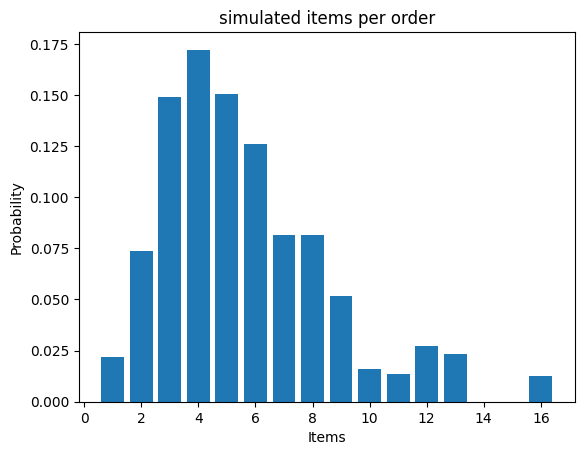

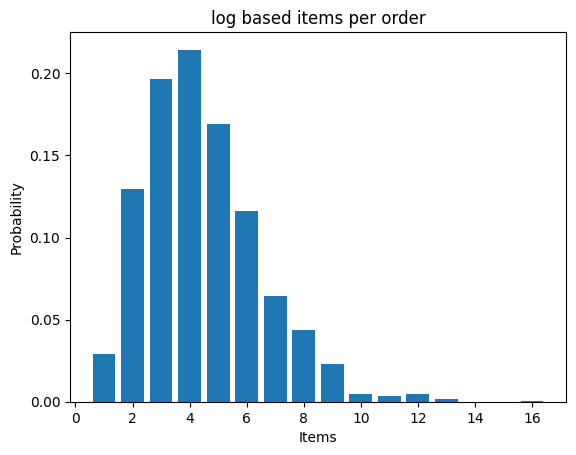

In [22]:
# OUTPUT ORMD TEST FOR ONE GRAPH
from collections import defaultdict 
order_items_counts = defaultdict(int)
for ob in o:
    if ob.type == "orders":
        count = 0
        for relation in ob.relations:
            if relation.type == "items":
                count = count+1
        order_items_counts[count] = order_items_counts[count]+1
print(order_items_counts)

total = sum(order_items_counts.values())

generateditemsPerOrder = {}
    
# Divide each value by the total to get the probability
for key, value in order_items_counts.items():
     generateditemsPerOrder[key] = value / total
     
plot(generateditemsPerOrder,"simulated items per order")
plot(calcORMDs(o2os=log.o2o,type1="orders",type2="items")[0], "log based items per order")


In [23]:
from pyemd import emd

In [24]:
logItemsPerOrder = calcORMDs(o2os=log.o2o,type1="orders",type2="items")
# Example distributions represented as dictionaries
distribution1 = logItemsPerOrder[0]
distribution2 = generateditemsPerOrder

sorted_keys = sorted(distribution1.keys())
array1 = np.array([distribution1[key] for key in sorted_keys])
sorted_keys = sorted(distribution2.keys())
array2 = np.array([distribution2[key] for key in sorted_keys])


#pad with zeros to achieve the same histogram length+
hist1 = array1
hist2 = array2
if len(hist1) > len(hist2):
    hist2 = np.pad(hist2, (0, len(hist1) - len(hist2)), 'constant')
elif len(hist1) < len(hist2):
    hist1 = np.pad(hist1, (0, len(hist2) - len(hist1)), 'constant')
    
array1 = hist1
array2 = hist2
# Compute the Earth Mover's Distance

distance_matrix = np.zeros((len(array1), len(array2)))
for i in range(len(array1)):
    for j in range(len(array2)):
        distance_matrix[i][j] = abs(i - j)




emd_distance = emd(array1, array2, distance_matrix=distance_matrix)
print("emd distance: " +str(emd_distance))


emd distance: 1.1609475694830014


In [25]:
# Replace string representations of missing values with np.nan
adjusted_log.replace(["NaN", "<NA>", "None"], np.nan, inplace=True)

# Convert any actual pd.NA or None to np.nan
adjusted_log = adjusted_log.applymap(lambda x: np.nan if pd.isna(x) else x)
adjusted_log

ocel:oid  role  weight   price            product  volume ocel:type  \
33     i-880001   NaN   0.495  129.00  Kindle Paperwhite     NaN     items   
34     i-880002   NaN   0.166  799.00          iPhone 11     NaN     items   
35     i-880003   NaN   1.480  199.99        Echo Studio     NaN     items   
36     i-880004   NaN   0.483  495.00               iPad     NaN     items   
37     i-880005   NaN   0.172  699.00           iPhone X     NaN     items   
...         ...   ...     ...     ...                ...     ...       ...   
11198  p-661144   NaN   4.361     NaN                NaN  218.05  packages   
11199  p-661145   NaN   5.561     NaN                NaN  556.10  packages   
11200  p-661146   NaN   3.531     NaN                NaN  176.55  packages   
11201  p-661147   NaN   4.493     NaN                NaN  224.65  packages   
11202  p-661148   NaN   7.778     NaN                NaN  777.80  packages   

      is_premium kdtyp  
33         False   NaN  
34          True   NaN  
35         False   NaN  
36         False   NaN  
37          True   NaN  
...          ...   ...  
11198        NaN   NaN  
11199        NaN   NaN  
11200        NaN   NaN  
11201        NaN   NaN  
11202        NaN   NaN  

[11170 rows x 9 columns]

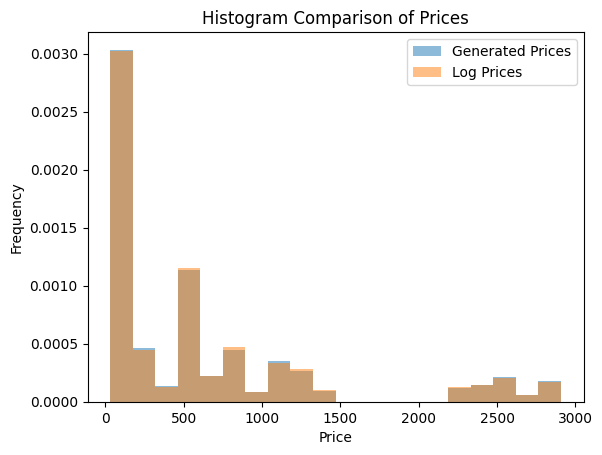

In [26]:
itemPricesGenerated = []
for ob in o:
    if ob.type == "items":
        itemPricesGenerated.append(ob.attributes["price"])
itemPricesLog = adjusted_log[adjusted_log['ocel:type'] == 'items']['price'].tolist()



# Assume prices1 and prices2 are your two lists of prices
plt.hist(itemPricesGenerated, bins=20, alpha=0.5, label='Generated Prices',density=True)
plt.hist(itemPricesLog, bins=20, alpha=0.5, label='Log Prices',density=True)

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram Comparison of Prices')
plt.legend(loc='upper right')
plt.show()

In [27]:
average_prices1 = sum(itemPricesGenerated) / len(itemPricesGenerated)
average_prices2 = sum(itemPricesLog) / len(itemPricesLog)
print(average_prices1)
print(average_prices2)

623.2873339801779
623.7450672043011


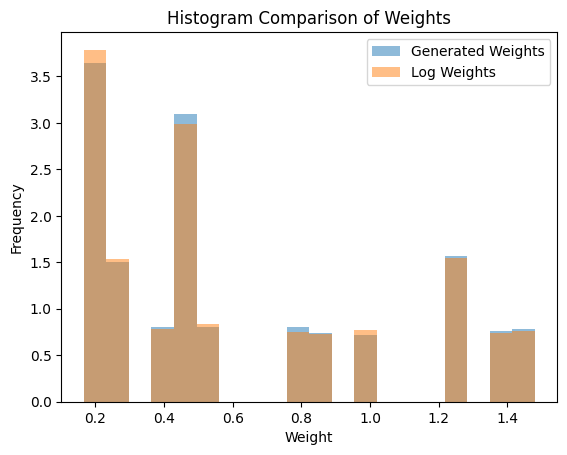

In [28]:
itemWeightsGenerated = []
for ob in o:
    if ob.type == "items":
        itemWeightsGenerated.append(ob.attributes["weight"])
itemWeightsLog = adjusted_log[adjusted_log['ocel:type'] == 'items']['weight'].tolist()
# Assume prices1 and prices2 are your two lists of prices
plt.hist(itemWeightsGenerated, bins=20, alpha=0.5, label='Generated Weights',density=True)
plt.hist(itemWeightsLog, bins=20, alpha=0.5, label='Log Weights',density=True)

plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Histogram Comparison of Weights')
plt.legend(loc='upper right')
plt.show()

In [29]:
average_weights1 = sum(itemWeightsGenerated) / len(itemWeightsGenerated)
average_weights2 = sum(itemWeightsLog) / len(itemWeightsLog)
print(average_weights1)
print(average_weights2)

0.6203678309616185
0.6134956011730205


In [30]:
# Assuming prices1 and prices2 are your two lists of prices
from pyemd import emd
# Define the number of bins and the range manually
prices1 = itemPricesLog
prices2 = itemPricesGenerated

num_bins = 10
min_edge = min(min(prices1), min(prices2))
max_edge = max(max(prices1), max(prices2))
bin_edges = np.linspace(min_edge, max_edge, num_bins + 1)

# Create histograms with the same bins
hist1, _ = np.histogram(prices1, bins=bin_edges, density=True)
hist2, _ = np.histogram(prices2, bins=bin_edges, density=True)

# Calculate bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Define the distance matrix
distance_matrix = np.abs(np.subtract.outer(bin_centers, bin_centers))

# Calculate the EMD
emd_value = emd(hist1, hist2, distance_matrix)

print(f"EMD between the two distributions: {emd_value}")

EMD between the two distributions: 0.019672980327001124


In [31]:
import numpy as np
from pyemd import emd

weights1 = itemWeightsLog
weights2 = itemWeightsGenerated

# Assuming weights1 and weights2 are your two lists of weights

# Define the number of bins
num_bins = 10

# Create histograms with the same range
hist1, bin_edges = np.histogram(weights1, bins=num_bins, range=(min(min(weights1), min(weights2)), max(max(weights1), max(weights2))), density=True)
hist2, _ = np.histogram(weights2, bins=bin_edges, density=True)

# Calculate bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Define the distance matrix
distance_matrix = np.abs(np.subtract.outer(bin_centers, bin_centers))

# Calculate the EMD
emd_value = emd(hist1, hist2, distance_matrix)

print(f"EMD between the two distributions: {emd_value}")


EMD between the two distributions: 0.048514967883000006


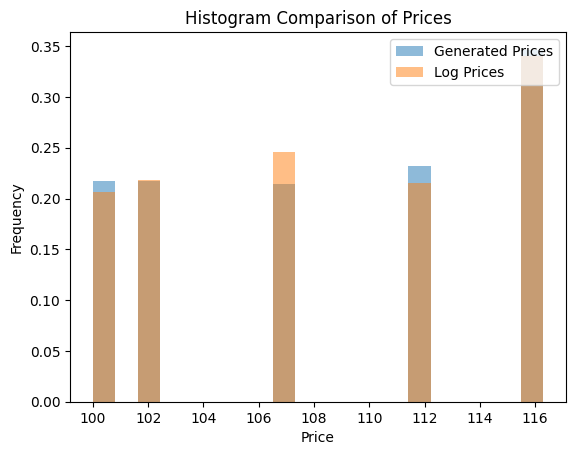

In [32]:
EchoPricesLog = adjusted_log[adjusted_log['product'] == 'Echo']['price'].tolist()
EchoPricesGenerated = []
for ob in o:
    if "product" in ob.attributes:
        if ob.attributes["product"] == "Echo":
            EchoPricesGenerated.append(ob.attributes["price"])
# Assume prices1 and prices2 are your two lists of prices
plt.hist(EchoPricesGenerated, bins=20, alpha=0.5, label='Generated Prices',density=True)
plt.hist(EchoPricesLog, bins=20, alpha=0.5, label='Log Prices',density=True)

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram Comparison of Prices')
plt.legend(loc='upper right')
plt.show()

In [33]:
print( sum(EchoPricesLog) / len(EchoPricesLog))
print(sum(EchoPricesGenerated) / len(EchoPricesGenerated))


108.30351485148516
108.35443089430913


Earth Mover's Distance: 0.01836900000000033


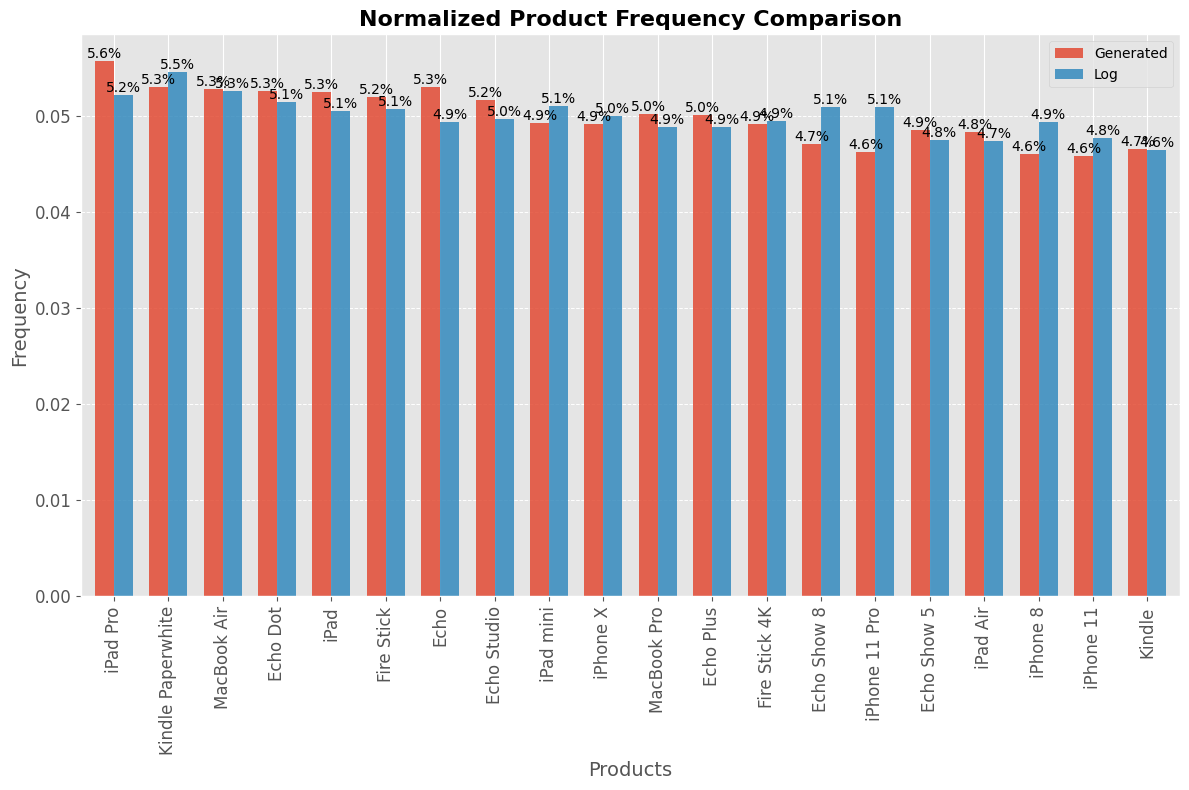

In [34]:
import collections
from pyemd import emd

productsGenerated = []
for ob in o:
    if ob.type == "items":
        productsGenerated.append(ob.attributes["product"])

productsLog = adjusted_log[adjusted_log['ocel:type'] == 'items']['product'].tolist()

# Counting frequencies
counter1 = collections.Counter(productsGenerated)
counter2 = collections.Counter(productsLog)

# Creating DataFrames
df1 = pd.DataFrame.from_dict(counter1, orient='index', columns=['Generated'])
df2 = pd.DataFrame.from_dict(counter2, orient='index', columns=['Log'])

# Combine DataFrames and fill missing values with 0
df_combined = pd.concat([df1, df2], axis=1).fillna(0).astype(int)

# Normalize the frequencies to get probabilities
df_combined['Generated'] /= df_combined['Generated'].sum()
df_combined['Log'] /= df_combined['Log'].sum()

# Sort by the total frequency (optional)
df_combined['Total'] = df_combined['Generated'] + df_combined['Log']
df_combined = df_combined.sort_values(by='Total', ascending=False).drop(columns='Total')

# Convert the probabilities to numpy arrays
P = df_combined['Generated'].values
Q = df_combined['Log'].values

# Create a distance matrix (assuming all products are equally distant)
n = len(P)
distance_matrix = np.ones((n, n)) - np.eye(n)  # Distance is 1 between different products, 0 for the same product

# Compute Earth Mover's Distance (EMD)
emd_value = emd(P, Q, distance_matrix)

# Print the EMD value
print(f"Earth Mover's Distance: {emd_value}")

# Plotting the normalized distributions with adjustments for clarity
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))  # Increased figure size

# Plot the data with reduced bar width and transparency
df_combined.plot(kind='bar', ax=ax, width=0.7, alpha=0.85)

# Labels and Titles
plt.title('Normalized Product Frequency Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Products', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Rotate x-axis labels more steeply to prevent overlap
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# Add horizontal gridlines for easier comparison
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Simplify the annotations to fewer decimal places
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1%}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black')

# Adjust layout for better fit
plt.tight_layout()
plt.show()


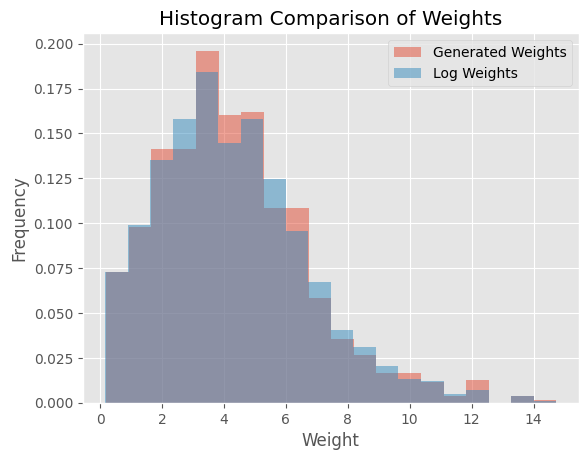

Earth Mover's Distance (EMD) between Generated Weights and Log Weights: 0.05386602018917299


In [35]:
packagesWeightsGenerated = []
for ob in o:
    if ob.type == "packages":
        packagesWeightsGenerated.append(ob.attributes["weight"])

packagesWeightsLog = adjusted_log[adjusted_log['ocel:type'] == 'packages']['weight'].tolist()

# Plot the histograms
plt.hist(packagesWeightsGenerated, bins=20, alpha=0.5, label='Generated Weights', density=True)
plt.hist(packagesWeightsLog, bins=20, alpha=0.5, label='Log Weights', density=True)

plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Histogram Comparison of Weights')
plt.legend(loc='upper right')
plt.show()

# ---- EMD Calculation ----
# Convert weights to numpy arrays
weights_generated = np.array(packagesWeightsGenerated)
weights_log = np.array(packagesWeightsLog)

# Calculate histograms for both generated and log weights (these serve as discrete probability distributions)
hist_generated, bin_edges_generated = np.histogram(weights_generated, bins=20, density=True)
hist_log, bin_edges_log = np.histogram(weights_log, bins=20, density=True)

# Use bin centers as representative values for the weights
bin_centers_generated = 0.5 * (bin_edges_generated[1:] + bin_edges_generated[:-1])
bin_centers_log = 0.5 * (bin_edges_log[1:] + bin_edges_log[:-1])

# Create distance matrix (Euclidean distance between bin centers)
n_bins = len(bin_centers_generated)
distance_matrix = np.abs(bin_centers_generated.reshape(-1, 1) - bin_centers_generated.reshape(1, -1))

# EMD requires the histograms to be normalized, ensuring they sum to 1 (probabilities)
hist_generated /= hist_generated.sum()
hist_log /= hist_log.sum()

# Compute EMD
emd_value = emd(hist_generated, hist_log, distance_matrix)

# Print the EMD value
print(f"Earth Mover's Distance (EMD) between Generated Weights and Log Weights: {emd_value}")


In [36]:
from scipy.stats import pearsonr


# Step 1: Filter objects of type 'packages' and extract 'volume' and 'weight' attributes
package_data = [(obj.attributes['volume'], obj.attributes['weight']) for obj in o if obj.type == 'packages']

# Step 2: Convert to a DataFrame for easier analysis
df = pd.DataFrame(package_data, columns=['volume', 'weight'])

# Step 3: Check for dependency using correlation
# Calculate the Pearson correlation coefficient for linear dependency
if not df.empty:
    correlation, p_value = pearsonr(df['volume'], df['weight'])
    print(f"Correlation coefficient: {correlation}")
    print(f"P-value: {p_value}")

    # Interpretation
    if abs(correlation) > 0.7:  # Threshold for strong correlation (adjust as needed)
        print("There is a strong dependency between volume and weight.")
    else:
        print("The dependency between volume and weight is weak or nonexistent.")
else:
    print("No 'packages' objects found in the list.")


Correlation coefficient: 0.9611632818341289
P-value: 0.0
There is a strong dependency between volume and weight.


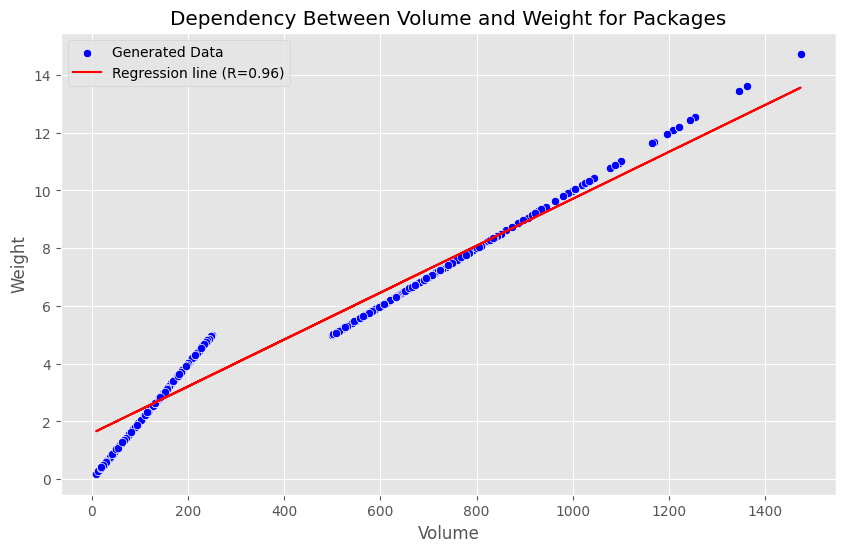

In [37]:

import seaborn as sns
from scipy.stats import linregress

# Step 1: Filter and prepare data for plotting
package_data = [(obj.attributes['volume'], obj.attributes['weight']) for obj in o if obj.type == 'packages']
df = pd.DataFrame(package_data, columns=['volume', 'weight'])

# Step 2: Plotting with Seaborn for scatter and optional regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='volume', y='weight', color='blue', label='Generated Data')

# Step 3: Add a regression line if you expect a linear dependency
slope, intercept, r_value, p_value, std_err = linregress(df['volume'], df['weight'])
plt.plot(df['volume'], slope * df['volume'] + intercept, color='red', label=f'Regression line (R={r_value:.2f})')

# Step 4: Customize the plot
plt.xlabel('Volume')
plt.ylabel('Weight')
plt.title('Dependency Between Volume and Weight for Packages')
plt.legend()
plt.show()


Original Correlation (filtered): 0.96
Generated Correlation: 0.96


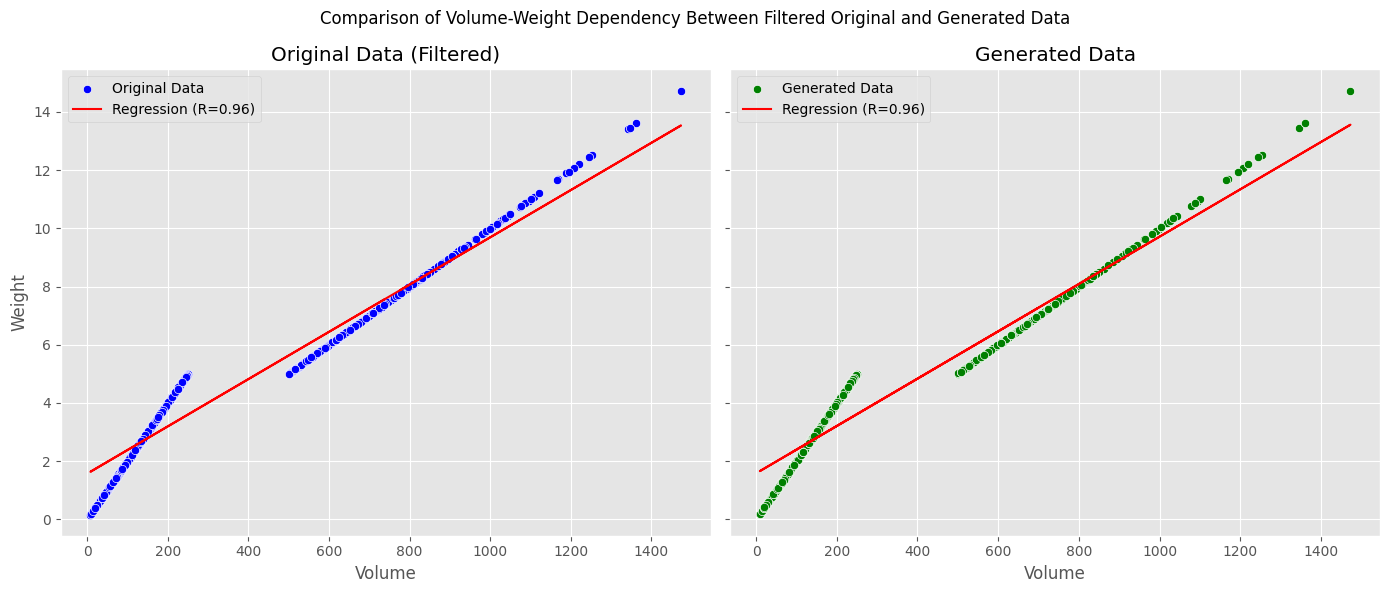

In [38]:

# Step 1: Filter 'adjusted_log' for rows where 'ocel:type' is 'packages' and both 'volume' and 'weight' are non-null
filtered_original_df = adjusted_log[(adjusted_log['ocel:type'] == 'packages') & 
                                    adjusted_log['volume'].notnull() & 
                                    adjusted_log['weight'].notnull()]

# Step 2: Calculate Pearson correlation for both filtered original data and generated data
# Original Data (filtered)
original_correlation, _ = pearsonr(filtered_original_df['volume'], filtered_original_df['weight'])

# Generated Data: Filter for packages only and create DataFrame
generated_data = [(obj.attributes['volume'], obj.attributes['weight']) for obj in o if obj.type == 'packages']
generated_df = pd.DataFrame(generated_data, columns=['volume', 'weight'])
generated_correlation, _ = pearsonr(generated_df['volume'], generated_df['weight'])

print(f"Original Correlation (filtered): {original_correlation:.2f}")
print(f"Generated Correlation: {generated_correlation:.2f}")

# Step 3: Plot side-by-side scatter plots with regression lines
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for Original Data (filtered)
sns.scatterplot(data=filtered_original_df, x='volume', y='weight', ax=axes[0], color='blue', label='Original Data')
slope_orig, intercept_orig, _, _, _ = linregress(filtered_original_df['volume'], filtered_original_df['weight'])
axes[0].plot(filtered_original_df['volume'], slope_orig * filtered_original_df['volume'] + intercept_orig, color='red', label=f'Regression (R={original_correlation:.2f})')
axes[0].set_title('Original Data (Filtered)')
axes[0].set_xlabel('Volume')
axes[0].set_ylabel('Weight')
axes[0].legend()

# Plot for Generated Data
sns.scatterplot(data=generated_df, x='volume', y='weight', ax=axes[1], color='green', label='Generated Data')
slope_gen, intercept_gen, _, _, _ = linregress(generated_df['volume'], generated_df['weight'])
axes[1].plot(generated_df['volume'], slope_gen * generated_df['volume'] + intercept_gen, color='red', label=f'Regression (R={generated_correlation:.2f})')
axes[1].set_title('Generated Data')
axes[1].set_xlabel('Volume')
axes[1].legend()

plt.suptitle('Comparison of Volume-Weight Dependency Between Filtered Original and Generated Data')
plt.tight_layout()
plt.show()


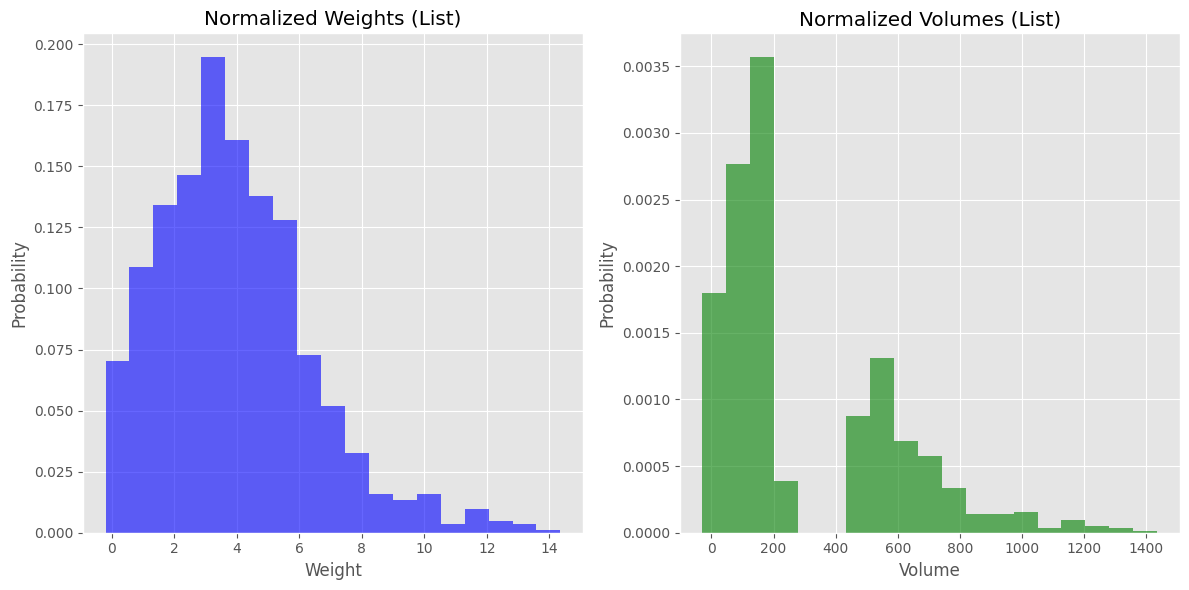

In [39]:

# Normalize weights and volumes from the list
weights_list = [obj.attributes['weight'] for obj in o if obj.type == 'packages']
volumes_list = [obj.attributes['volume'] for obj in o if obj.type == 'packages']

# Compute histograms for the list (normalized to form probability distributions)
bins_weights_list = np.linspace(min(weights_list), max(weights_list), 20)
hist_weights_list, edges_weights_list = np.histogram(weights_list, bins=bins_weights_list, density=True)

bins_volumes_list = np.linspace(min(volumes_list), max(volumes_list), 20)
hist_volumes_list, edges_volumes_list = np.histogram(volumes_list, bins=bins_volumes_list, density=True)

# Plot normalized distributions from the list
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(edges_weights_list[:-1], hist_weights_list, width=np.diff(edges_weights_list), alpha=0.6, color='blue', label='Weights')
plt.title("Normalized Weights (List)")
plt.xlabel("Weight")
plt.ylabel("Probability")

plt.subplot(1, 2, 2)
plt.bar(edges_volumes_list[:-1], hist_volumes_list, width=np.diff(edges_volumes_list), alpha=0.6, color='green', label='Volumes')
plt.title("Normalized Volumes (List)")
plt.xlabel("Volume")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()


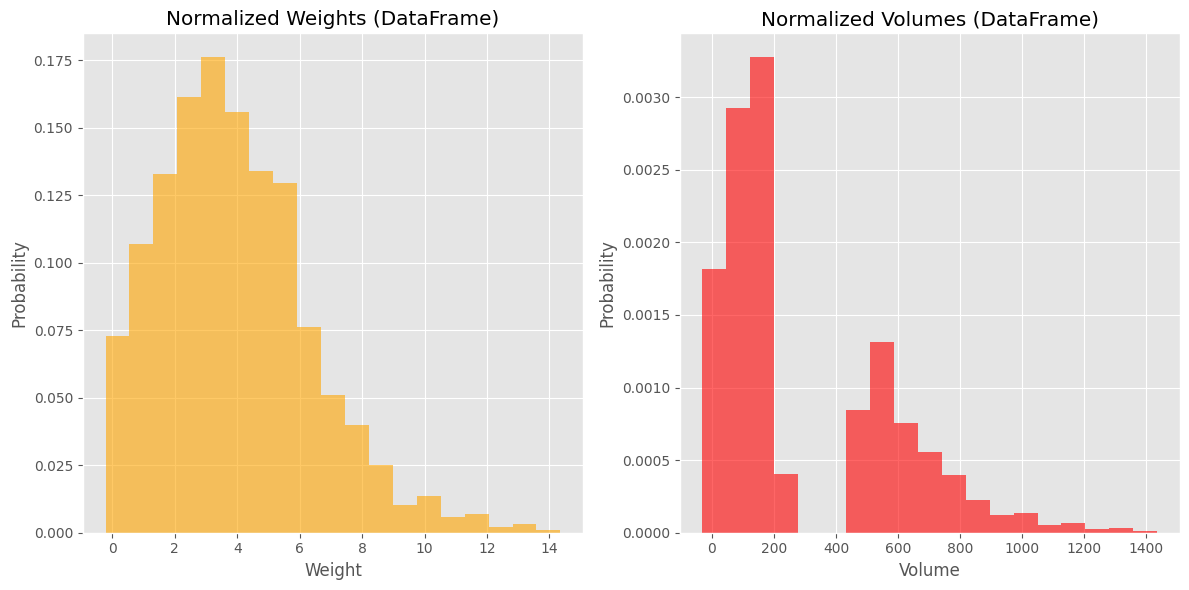

In [40]:
# Extract weights and volumes from the dataframe
weights_df = filtered_original_df['weight']
volumes_df = filtered_original_df['volume']

# Compute histograms for the dataframe (normalized to form probability distributions)
bins_weights_df = np.linspace(weights_df.min(), weights_df.max(), 20)
hist_weights_df, edges_weights_df = np.histogram(weights_df, bins=bins_weights_df, density=True)

bins_volumes_df = np.linspace(volumes_df.min(), volumes_df.max(), 20)
hist_volumes_df, edges_volumes_df = np.histogram(volumes_df, bins=bins_volumes_df, density=True)

# Plot normalized distributions from the dataframe
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(edges_weights_df[:-1], hist_weights_df, width=np.diff(edges_weights_df), alpha=0.6, color='orange', label='Weights')
plt.title("Normalized Weights (DataFrame)")
plt.xlabel("Weight")
plt.ylabel("Probability")

plt.subplot(1, 2, 2)
plt.bar(edges_volumes_df[:-1], hist_volumes_df, width=np.diff(edges_volumes_df), alpha=0.6, color='red', label='Volumes')
plt.title("Normalized Volumes (DataFrame)")
plt.xlabel("Volume")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()


In [41]:
from pyemd import emd

# Ensure the same bins for comparison (combining range from both datasets)
combined_bins_weights = np.linspace(
    min(min(weights_list), weights_df.min()), 
    max(max(weights_list), weights_df.max()), 
    20
)
combined_bins_volumes = np.linspace(
    min(min(volumes_list), volumes_df.min()), 
    max(max(volumes_list), volumes_df.max()), 
    20
)

# Compute normalized histograms with combined bins
hist_weights_list_combined, _ = np.histogram(weights_list, bins=combined_bins_weights, density=True)
hist_weights_df_combined, _ = np.histogram(weights_df, bins=combined_bins_weights, density=True)

hist_volumes_list_combined, _ = np.histogram(volumes_list, bins=combined_bins_volumes, density=True)
hist_volumes_df_combined, _ = np.histogram(volumes_df, bins=combined_bins_volumes, density=True)

# Compute bin centers for the distance matrix
bin_centers_weights = (combined_bins_weights[:-1] + combined_bins_weights[1:]) / 2
bin_centers_volumes = (combined_bins_volumes[:-1] + combined_bins_volumes[1:]) / 2

# Cost matrices
cost_matrix_weights = np.abs(bin_centers_weights[:, None] - bin_centers_weights[None, :])
cost_matrix_volumes = np.abs(bin_centers_volumes[:, None] - bin_centers_volumes[None, :])

# Compute EMD
emd_weights = emd(hist_weights_list_combined, hist_weights_df_combined, cost_matrix_weights)
emd_volumes = emd(hist_volumes_list_combined, hist_volumes_df_combined, cost_matrix_volumes)

print(f"EMD for Weights: {emd_weights}")
print(f"EMD for Volumes: {emd_volumes}")


EMD for Weights: 0.07253213675399998
EMD for Volumes: 0.08526708343799999


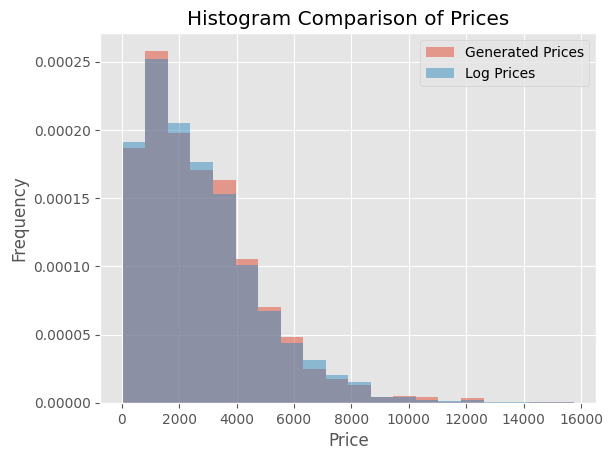

Earth Mover's Distance (EMD) between Generated Prices and Log Prices: 34.44525911114802


In [42]:
orderPricesGenerated = []
for ob in o:
    if ob.type == "orders":
        if "price" in ob.attributes:
            orderPricesGenerated.append(ob.attributes["price"])

orderPricesLog = adjusted_log[adjusted_log['ocel:type'] == 'orders']['price'].tolist()

# Plot the histograms
plt.hist(orderPricesGenerated, bins=20, alpha=0.5, label='Generated Prices', density=True)
plt.hist(orderPricesLog, bins=20, alpha=0.5, label='Log Prices', density=True)

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram Comparison of Prices')
plt.legend(loc='upper right')
plt.show()

# ---- EMD Calculation ----
# Convert weights to numpy arrays
weights_generated = np.array(orderPricesGenerated)
weights_log = np.array(orderPricesLog)

# Calculate histograms for both generated and log weights (these serve as discrete probability distributions)
hist_generated, bin_edges_generated = np.histogram(weights_generated, bins=20, density=True)
hist_log, bin_edges_log = np.histogram(weights_log, bins=20, density=True)

# Use bin centers as representative values for the weights
bin_centers_generated = 0.5 * (bin_edges_generated[1:] + bin_edges_generated[:-1])
bin_centers_log = 0.5 * (bin_edges_log[1:] + bin_edges_log[:-1])

# Create distance matrix (Euclidean distance between bin centers)
n_bins = len(bin_centers_generated)
distance_matrix = np.abs(bin_centers_generated.reshape(-1, 1) - bin_centers_generated.reshape(1, -1))

# EMD requires the histograms to be normalized, ensuring they sum to 1 (probabilities)
hist_generated /= hist_generated.sum()
hist_log /= hist_log.sum()

# Compute EMD
emd_value = emd(hist_generated, hist_log, distance_matrix)

# Print the EMD value
print(f"Earth Mover's Distance (EMD) between Generated Prices and Log Prices: {emd_value}")

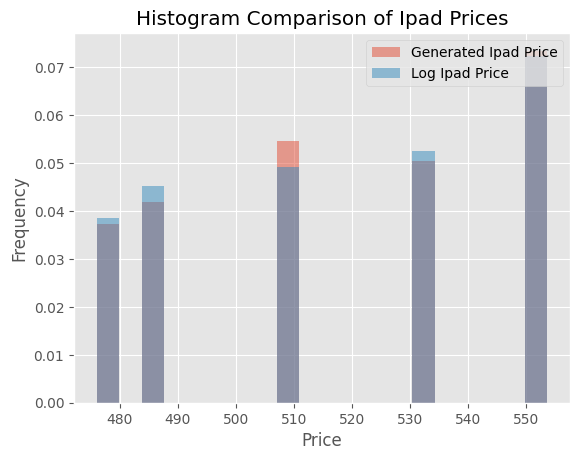

In [43]:
#evaluate dep atts
#make distributions of dep atts limited to cases in which dependency present
#first dependencies between same object type
#dependency (product,items) -> (price,items)
ProdPriceLog = []
ProdPriceGenerated = []
for ob in o:
    if ob.type == "items" and ob.attributes["product"]=="iPad Air":
        ProdPriceGenerated.append(ob.attributes["price"])
#ProdPriceLog = adjusted_log[adjusted_log['ocel:type'] == 'items' and adjusted_log['product'] == 'iPad Air']['price'].tolist()
ProdPriceLog = adjusted_log[(adjusted_log['ocel:type'] == 'items') & (adjusted_log['product'] == 'iPad Air')]['price'].tolist()
plt.hist(ProdPriceGenerated, bins=20, alpha=0.5, label='Generated Ipad Price',density=True)
plt.hist(ProdPriceLog, bins=20, alpha=0.5, label='Log Ipad Price',density=True)

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram Comparison of Ipad Prices')
plt.legend(loc='upper right')
plt.show()


In [44]:
#evaluate mias
#look at items per order depending on value of kdtyp
o2os = log.o2o
objects = newLog

# Step 1: Filter `o2os` to get relationships where orders comprise items
order_item_relationships = o2os[o2os['ocel:type'] == 'orders'][['ocel:oid', 'ocel:oid_2']]
order_item_relationships = order_item_relationships.rename(columns={'ocel:oid': 'order_oid', 'ocel:oid_2': 'item_oid'})

# Step 2: Count the number of items per order
item_counts_per_order = order_item_relationships.groupby('order_oid').size().reset_index(name='item_count')

# Step 3: Merge item counts with orders in `objects` to add `kdtyp`
orders_with_kdtyp = objects[objects['ocel:type'] == 'orders'][['ocel:oid', 'kdtyp']]
orders_with_kdtyp = orders_with_kdtyp.rename(columns={'ocel:oid': 'order_oid'})

# Merge item counts with orders to add `kdtyp` and item count
orders_with_item_counts = orders_with_kdtyp.merge(item_counts_per_order, on='order_oid', how='left')

# Step 4: Calculate statistics for item counts by kdtyp
kdtyp_analysis = orders_with_item_counts.groupby('kdtyp')['item_count'].agg(
    count='count',
    mean='mean',
    median='median',
    min='min',
    max='max',
    std='std'
).fillna(0)  # Fill NaNs with 0 if any `kdtyp` group has no items

# Print the result
print("Dependency between kdtyp and item count:\n", kdtyp_analysis)

Dependency between kdtyp and item count:
        count      mean  median  min  max       std
kdtyp                                             
GR       862  3.900232     4.0    1   16  1.962902
PR       976  4.940574     5.0    2   13  1.957642


Dependency between kdtyp and item count:
        count      mean  median  min  max       std
kdtyp                                             
GR       862  3.900232     4.0    1   16  1.962902
PR       976  4.940574     5.0    2   13  1.957642


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


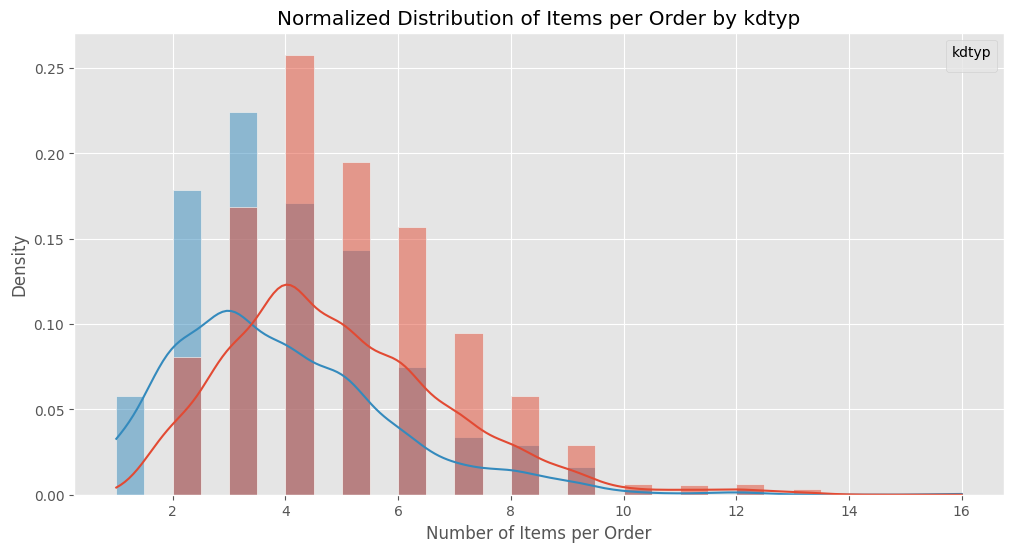

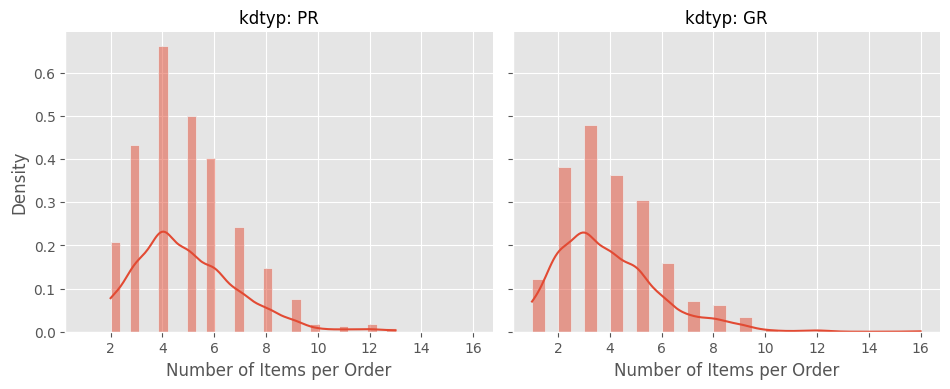

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Existing code setup
o2os = log.o2o
objects = newLog

# Step 1: Filter `o2os` to get relationships where orders comprise items
order_item_relationships = o2os[o2os['ocel:type'] == 'orders'][['ocel:oid', 'ocel:oid_2']]
order_item_relationships = order_item_relationships.rename(columns={'ocel:oid': 'order_oid', 'ocel:oid_2': 'item_oid'})

# Step 2: Count the number of items per order
item_counts_per_order = order_item_relationships.groupby('order_oid').size().reset_index(name='item_count')

# Step 3: Merge item counts with orders in `objects` to add `kdtyp`
orders_with_kdtyp = objects[objects['ocel:type'] == 'orders'][['ocel:oid', 'kdtyp']]
orders_with_kdtyp = orders_with_kdtyp.rename(columns={'ocel:oid': 'order_oid'})

# Merge item counts with orders to add `kdtyp` and item count
orders_with_item_counts = orders_with_kdtyp.merge(item_counts_per_order, on='order_oid', how='left')

# Step 4: Calculate statistics for item counts by kdtyp
kdtyp_analysis = orders_with_item_counts.groupby('kdtyp')['item_count'].agg(
    count='count',
    mean='mean',
    median='median',
    min='min',
    max='max',
    std='std'
).fillna(0)  # Fill NaNs with 0 if any `kdtyp` group has no items

# Print the result
print("Dependency between kdtyp and item count:\n", kdtyp_analysis)

# Step 5: Plot normalized distribution of items per order based on `kdtyp`
plt.figure(figsize=(12, 6))
sns.histplot(data=orders_with_item_counts, x='item_count', hue='kdtyp', kde=True, bins=30, stat="density")
plt.title('Normalized Distribution of Items per Order by kdtyp')
plt.xlabel('Number of Items per Order')
plt.ylabel('Density')
plt.legend(title='kdtyp')
plt.show()

# Optionally, using FacetGrid to show separate normalized distributions for each kdtyp
g = sns.FacetGrid(orders_with_item_counts, col='kdtyp', height=4, aspect=1.2)
g.map(sns.histplot, 'item_count', kde=True, bins=30, stat="density")
g.set_axis_labels('Number of Items per Order', 'Density')
g.set_titles("kdtyp: {col_name}")
plt.show()


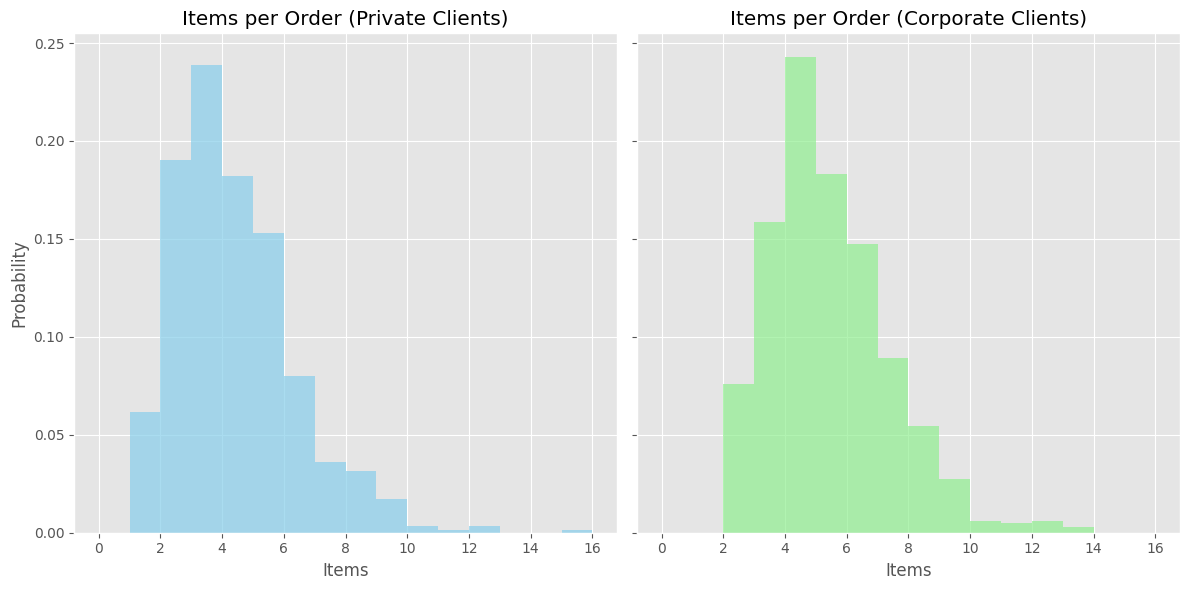

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `orders_with_item_counts` is prepared as before
# Filter data based on `kdtyp` for "Private Clients" and "Corporate Clients" (adjust labels as needed)
private_clients = orders_with_item_counts[orders_with_item_counts['kdtyp'] == 'GR']
corporate_clients = orders_with_item_counts[orders_with_item_counts['kdtyp'] == 'PR']



# Set up the figure and axis
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot for Private Clients
axes[0].hist(private_clients['item_count'], bins=range(0, 17), color='skyblue', density=True, alpha=0.7)
axes[0].set_title("Items per Order (Private Clients)")
axes[0].set_xlabel("Items")
axes[0].set_ylabel("Probability")

# Plot for Corporate Clients
axes[1].hist(corporate_clients['item_count'], bins=range(0, 17), color='lightgreen', density=True, alpha=0.7)
axes[1].set_title("Items per Order (Corporate Clients)")
axes[1].set_xlabel("Items")

# Display the plot
plt.tight_layout()
plt.show()


In [47]:
orders_with_item_counts

order_oid kdtyp  item_count
0     o-990001    PR           5
1     o-990002    GR           8
2     o-990003    GR           3
3     o-990004    GR           2
4     o-990005    PR           6
...        ...   ...         ...
1833  o-991834    PR           5
1834  o-991835    GR           2
1835  o-991836    PR           6
1836  o-991837    PR           4
1837  o-991838    GR           3

[1838 rows x 3 columns]

In [48]:
items = []
ordersPR = []
ordersGR = []
for obj in o:
    if obj.type == "items":
        items.append(obj.attributes["id"])
for obj in o:
    if obj.type == "orders" and "kdtyp" in obj.attributes:
        if obj.attributes["kdtyp"]== "GR":
            ordersGR.append(obj.attributes["id"])
for obj in o:
    if obj.type == "orders" and "kdtyp" in obj.attributes:
        if obj.attributes["kdtyp"]== "PR":
            ordersPR.append(obj.attributes["id"])
PR = dict.fromkeys(ordersPR)
GR = dict.fromkeys(ordersGR)
for x in PR:
    PR[x]=0
for x in GR:
    GR[x]=0
for (ob1,ob2) in connections:
    if ob1 in ordersPR:
        if ob2 in items:
            PR[ob1]+=1
    if ob1 in ordersGR:
        if ob2 in items:
            GR[ob1]+=1





values1 = GR.values()
total1 = sum(values1)
count1 = len(values1)
# Calculate the average
average1 = total1 / count1

values2 = PR.values()
total2 = sum(values2)
count2 = len(values2)
# Calculate the average
average2 = total2 / count2

# Count the occurrences of each value in both lists
count1 = Counter(values1)
count2 = Counter(values2)

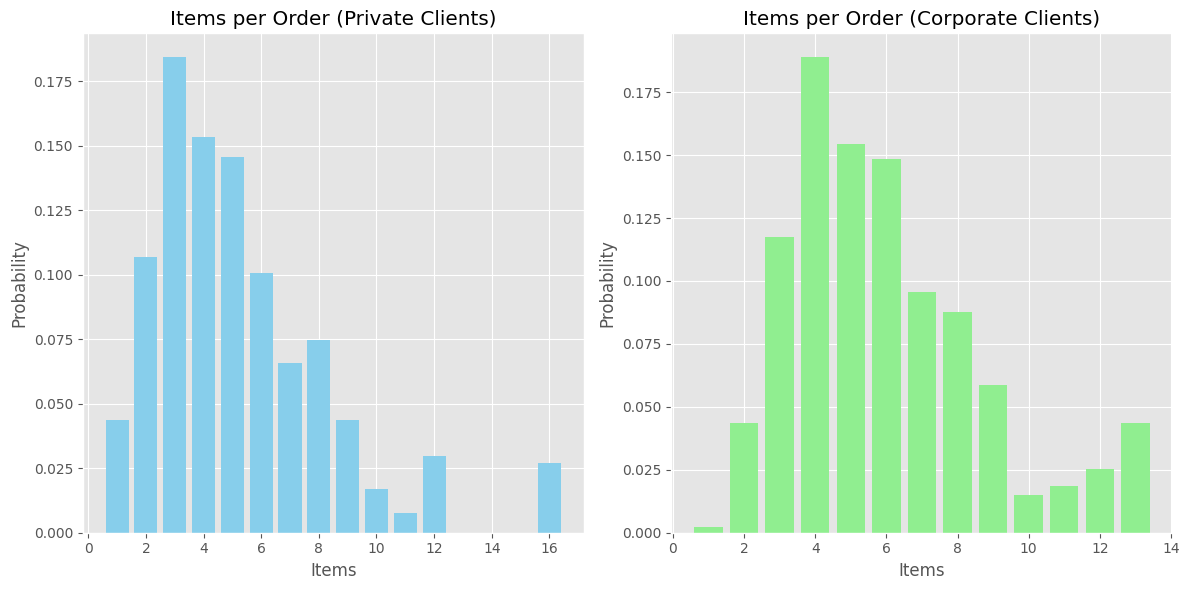

GR average items per order:5.248711340206185
PR average items per order:5.986175115207374


In [49]:
items = []
ordersPR = []
ordersGR = []
for obj in o:
    if obj.type == "items":
        items.append(obj.attributes["id"])
for obj in o:
    if obj.type == "orders" and "kdtyp" in obj.attributes:
        if obj.attributes["kdtyp"]== "GR":
            ordersGR.append(obj.attributes["id"])
for obj in o:
    if obj.type == "orders" and "kdtyp" in obj.attributes:
        if obj.attributes["kdtyp"]== "PR":
            ordersPR.append(obj.attributes["id"])
PR = dict.fromkeys(ordersPR)
GR = dict.fromkeys(ordersGR)
for x in PR:
    PR[x]=0
for x in GR:
    GR[x]=0
for (ob1,ob2) in connections:
    if ob1 in ordersPR:
        if ob2 in items:
            PR[ob1]+=1
    if ob1 in ordersGR:
        if ob2 in items:
            GR[ob1]+=1


values1 = GR.values()
total1 = sum(values1)
count1 = len(values1)
# Calculate the average
average1 = total1 / count1

values2 = PR.values()
total2 = sum(values2)
count2 = len(values2)
# Calculate the average
average2 = total2 / count2

# Count the occurrences of each value in both lists
count1 = Counter(values1)
count2 = Counter(values2)

# Prepare the data for plotting
labels1 = list(count1.keys())  # Unique values from the first list
counts1 = list(count1.values())  # Counts from the first list

labels2 = list(count2.keys())  # Unique values from the second list
counts2 = list(count2.values())  # Counts from the second list

# Normalize the counts (convert to proportions)
total1 = sum(counts1)
total2 = sum(counts2)

normalized_counts1 = [count / total1 for count in counts1]
normalized_counts2 = [count / total2 for count in counts2]

# Create a figure with two subplots (side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the normalized bar chart for the first list
axes[0].bar(labels1, normalized_counts1, color='skyblue')
axes[0].set_title('Items per Order (Private Clients)')
axes[0].set_xlabel('Items')
axes[0].set_ylabel('Probability')

# Plot the normalized bar chart for the second list
axes[1].bar(labels2, normalized_counts2, color='lightgreen')
axes[1].set_title('Items per Order (Corporate Clients)')
axes[1].set_xlabel('Items')
axes[1].set_ylabel('Probability')

# Show the charts
plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()

print("GR average items per order:" + str(average1))
print("PR average items per order:" + str(average2))


In [50]:
import numpy as np
from pyemd import emd

# Define the bins (common for both log and simulation data)
bins = np.arange(0, 17)  # Bins from the histogram

# Log-generated distributions (normalized histograms)
private_hist, _ = np.histogram(private_clients['item_count'], bins=bins, density=True)
corporate_hist, _ = np.histogram(corporate_clients['item_count'], bins=bins, density=True)

# Simulation-generated distributions
# Align and normalize distributions for Private Clients
sim_private_probs = np.zeros(len(bins) - 1)  # Initialize with zeros
for i, label in enumerate(labels1):
    sim_private_probs[bins[:-1] == label] = normalized_counts1[i]

# Align and normalize distributions for Corporate Clients
sim_corporate_probs = np.zeros(len(bins) - 1)  # Initialize with zeros
for i, label in enumerate(labels2):
    sim_corporate_probs[bins[:-1] == label] = normalized_counts2[i]

# Compute the distance matrix (using bin centers)
bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Bin centers
distance_matrix = np.abs(bin_centers[:, None] - bin_centers[None, :])  # Pairwise distances

# Calculate EMD for Private Clients
emd_private = emd(private_hist, sim_private_probs, distance_matrix)

# Calculate EMD for Corporate Clients
emd_corporate = emd(corporate_hist, sim_corporate_probs, distance_matrix)

# Print results
print(f"EMD between Private Clients (Log vs Simulation): {emd_private}")
print(f"EMD between Corporate Clients (Log vs Simulation): {emd_corporate}")


EMD between Private Clients (Log vs Simulation): 1.3659924179565466
EMD between Corporate Clients (Log vs Simulation): 1.0502032807050052


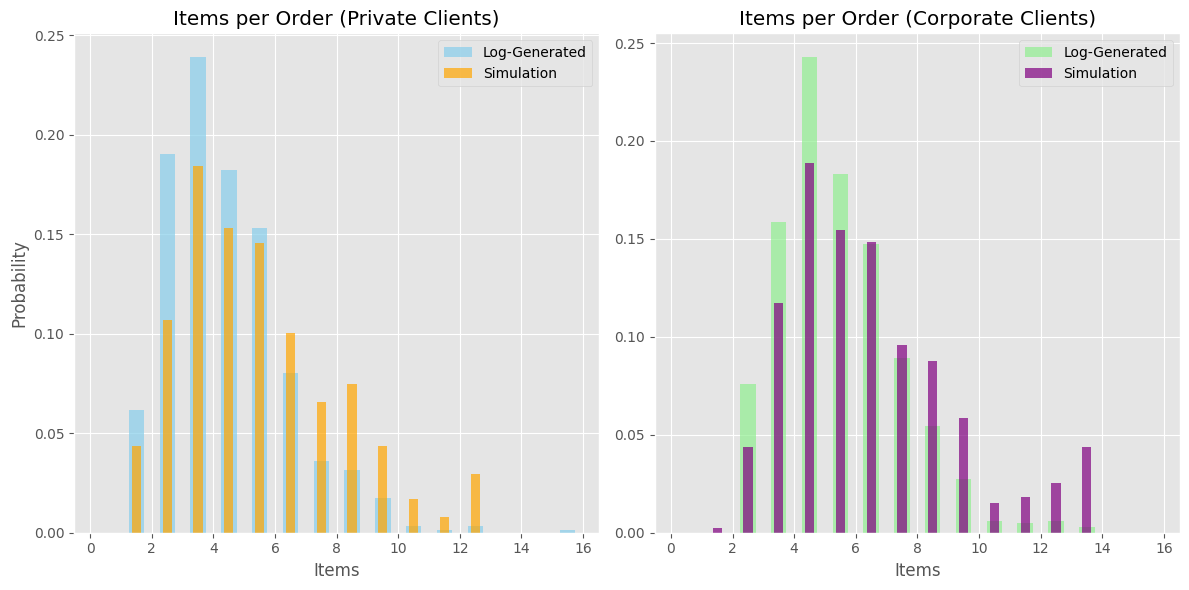

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Define the bins (common for both log and simulation data)
bins = np.arange(0, 17)  # Bins from the histogram
bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Bin centers

# Normalize histograms (log-generated distributions)
private_hist, _ = np.histogram(private_clients['item_count'], bins=bins, density=True)
corporate_hist, _ = np.histogram(corporate_clients['item_count'], bins=bins, density=True)

# Simulation-generated distributions (aligned bins)
sim_private_probs = np.zeros(len(bins) - 1)  # Initialize with zeros
for i, label in enumerate(labels1):
    sim_private_probs[bins[:-1] == label] = normalized_counts1[i]

sim_corporate_probs = np.zeros(len(bins) - 1)  # Initialize with zeros
for i, label in enumerate(labels2):
    sim_corporate_probs[bins[:-1] == label] = normalized_counts2[i]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Private Clients
axes[0].bar(bin_centers, private_hist, width=0.5, color='skyblue', alpha=0.7, label='Log-Generated')
axes[0].bar(bin_centers, sim_private_probs, width=0.3, color='orange', alpha=0.7, label='Simulation')
axes[0].set_title("Items per Order (Private Clients)")
axes[0].set_xlabel("Items")
axes[0].set_ylabel("Probability")
axes[0].legend()

# Plot for Corporate Clients
axes[1].bar(bin_centers, corporate_hist, width=0.5, color='lightgreen', alpha=0.7, label='Log-Generated')
axes[1].bar(bin_centers, sim_corporate_probs, width=0.3, color='purple', alpha=0.7, label='Simulation')
axes[1].set_title("Items per Order (Corporate Clients)")
axes[1].set_xlabel("Items")
axes[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()
